# Vitesse de réponse aux crises financières et paramètres structurels des pays

## Par Saad ABDELLAOUI ANDALOUSSI MAANE & Patrick Junior HOUNKPE

# Introduction

Les crises économiques et financières révèlent les fragilités structurelles des pays et redéfinissent durablement les équilibres macroéconomiques mondiaux. Si l’ampleur d’une crise est souvent mesurée à travers la contraction du PIB, un enjeu tout aussi fondamental réside dans la **capacité de reprise** : combien de temps un pays met-il à restaurer son niveau d’activité antérieur, et quels mécanismes favorisent ou freinent ce retour à la normale?

La résilience économique ne dépend pas uniquement de la richesse produite, mais aussi de paramètres tels que l’ouverture commerciale, la stabilité institutionnelle ou encore d'autres paramètres. Dans ce contexte, le **temps de reprise post-crise** peut être vu comme un indicateur synthétique de performance dynamique, complémentaire aux mesures statiques de puissance économique ou de développement.

L’objectif de ce projet est d’explorer et de modéliser ces dynamiques de reprise à l’échelle internationale, en s’appuyant sur des outils d’économétrie pour mieux comprendre les trajectoires économiques après chocs majeurs.

**NB1 :** Par souci de lisibilité, certaines fonctions ont été externalisées dans des scripts.  
**NB2 :** Certaines visualisations cartographiques utilisées sont interactives et peuvent ne pas être prises en charge sur toutes les plateformes de rendu.


## Sommaire

1. [Installation des packages](#installation-des-packages)
2. [Préparation des données](#préparation-des-données)
3. [Codes ISO-2 et ISO-3 relatifs aux pays](#2-codes-iso-des-pays)
4. [PIB réel](#3-pib-réel)
   - [Valeurs manquantes](#valeurs-manquantes)
   - [Évolution du PIB mondial](#evolution-du-pib-mondial)
   - [Analyse du PIB par quartiles](#analyse-interquartiles)
   - [Ajout de la variable poids économique](#ajout-de-la-variable-poids-economique)
   - [Clustering (K-Means)](#clustering)
5. [Importations et exportations](#importations-et-exportations)
   - [Pays exportateurs nets](#classification-en-pays-exportateurs-nets)
   - [Visualisation sur une carte](#visualisation-sur-une-carte)
6. [Analyse des pays enclavés](#5-analyse-des-pays-enclavés)
7. [Indice de développement humain (IDH)](#6-indice-de-développement-humain-idh)
- [Fusion des bases](#fusion-des-bases)
- [Standardisation des variables](#standardisation-des-variables)
- [Étude des corrélations](#etude-des-corrélations)
8. [Analyse quantitative par Régression](#implémentation-de-la-régression)
9. [Conclusion](#conclusion)


# Installation des packages

In [1]:
%pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scripts import data_collector as dc
from scripts import data_cleaner as dcl
from scripts import data_analysis as da
from scripts import data_visualization as dv
from scripts import regression as rg

# Préparation des données

## 1. Adresses de scraping utilisées

In [3]:
landlocked_url = "https://en.wikipedia.org/wiki/List_of_countries_by_length_of_coastline"
codesISO_url = "https://en.wikipedia.org/wiki/List_of_ISO_3166_country_codes"

## 2. Codes ISO des pays

Pourquoi nous fallait-il les codes ISO des pays et pas seulement leurs noms? 

L'explication est la suivante:

- **Nettoyer les jeux de données** qui ne contiennent pas uniquement des pays, mais également des communautés géographiques, des régions sous tutelle, etc.

- **Comparer des bases de données** ne portant pas exactement sur les mêmes ensembles de pays. Uniformiser les identifiants des pays avec les codes ISO nous permettrait de réaliser des opérations de jointures sur des bases de données n'ayant pas forcément les mêmes identifiants.

Nous avons donc scrappé cette liste de codes ISO sur [Wikipédia](https://en.wikipedia.org/wiki/List_of_ISO_3166_country_codes).


Par ailleurs, au cours de l'exécution du projet, nous avons fait face à un moment à une indisponibilité de la page Wikipédia. Cela nous a donc conduit à sauvegarder une version backup du fichier. Ainsi avec le code suivant nous essayons de récupérer les codes ISO directement depuis Wikipédia et si cela ne marche pas on se rabat sur la version locale sauvegardée.

In [4]:
try:
    codesISO_data = dc.get_ISOcodes(codesISO_url)
    codesISO_data = dcl.clean_ISOData(codesISO_data)
except Exception as e:
    print(f"An error occurred while fetching or cleaning ISO codes data: {e}")
    codesISO_data = pd.read_csv("data/ISO_data.csv")
    codesISO_data.drop(columns=['Unnamed: 0'], inplace=True)
    
codesISO_data

,Pays,ISO-2,ISO-3
0,Afghanistan,AF,AFG
1,Albania,AL,ALB
2,Algeria,DZ,DZA
3,Andorra,AD,AND
4,Angola,AO,AGO
...,...,...,...
188,Venezuela (Bolivarian Republic of),VE,VEN
189,Viet Nam[ak],VN,VNM
190,Yemen,YE,YEM
191,Zambia,ZM,ZMB


## 3. PIB Réel

Notre variable d’intérêt ici est le PIB réel, qui mesure la valeur de la production de biens et de services d’un pays corrigée des variations de prix.

Quelle est donc l'utilité du PIB Réel comparativement au PIB nominal?

- Contrairement au PIB nominal, le PIB réel permet de comparer les niveaux de production dans le temps et entre pays en *neutralisant l’effet de l’inflation*.
- Il est exprimé à *prix constants*, généralement par référence à une année de base. 

De fait, le PIB réel constitue ainsi un indicateur de l’activité économique et du niveau de richesse réellement produit par une économie.


Dans la suite, nous avons créé une fonction dans le dossier `scripts` qui permet de se connecter à l'API de la [World Bank](https://data.worldbank.org/) pour récupérer des données sur les indicateurs de nos choix concernant certains pays de nos choix. Une fois les données récupérées nous les structurons afin de faciliter les analyses à posteriori.

En l'occurence ici, nous récupérons les données du PIB Réel entre 1990 et 2024 sur les pays contenus dans la liste des codes ISO précédemment chargés.

In [ ]:
worldBank = dc.WorldBankData()

# Récupérer le PIB réel pour tous les pays du monde entre 1900 et 2024
liste_pays = codesISO_data["ISO-3"].tolist()
PIB_Reel_data = worldBank.get_indicator("PIB", liste_pays, start=1990, end=2024)

Par la suite, notre objectif était d'assigner à la matrice des données du PIB Réel une correspondance entre le nom en toutes lettres du pays et son code ISO. Dans ce processus, nous remarquons qu'il y a des problèmes avec les correspondances de noms entre les codes ISO et les noms des pays dans le dataframe `PIB_reel_data`. 

Un exemple de problème est le suivant:

Dans le dataframe `codesISO_data` des codes ISO, il y a des caractères indésirables au niveau des noms de certains pays (Viet Nam[ak], Venezuela (Bolivarian Republic of),...). Cela peut donc causer des problèmes lorsqu'on essaye de faire un matching entre ces pays et ceux contenus dans le dataframe `PIB_Reel_data`. 

Pour donc palier à cela nous avons développé un algorithme sur les chaînes de caractères qui permet de supprimer les caractères indésirables et de réaliser le matching entre les pays et leurs codes ISO.

In [6]:
PIB_countries = set(PIB_Reel_data["country"].unique())
ISO_countries = set(codesISO_data["Pays"].unique())

matching_dictionnary = {}

# Récupérer les pays avec un seul mot dans leur nom
single_word_countries = set(PIB_Reel_data[PIB_Reel_data['country'].str.split().str.len() == 1]['country'].tolist())
ISO_complicated_word_countries = ISO_countries 
potential_matching_complicated_word_countries = PIB_countries 

# Premier algorithme de matching basé sur les pays où les noms n'ont pas des caractères bizarres mais juste plusieurs mots
solved_ISO_complicated_word_countries = set()
solved_potential_matching_word_countries = set()

for iso_country in ISO_complicated_word_countries:
    for pib_country in potential_matching_complicated_word_countries:
        if iso_country in pib_country or pib_country in iso_country:
            matching_dictionnary[pib_country] = iso_country
            solved_ISO_complicated_word_countries.add(iso_country)
            solved_potential_matching_word_countries.add(pib_country)
            

# Afficher les pays non résolus après le premier algorithme
unresolved_ISO_countries = ISO_complicated_word_countries - solved_ISO_complicated_word_countries
unresolved_potential_matching_countries = potential_matching_complicated_word_countries - solved_potential_matching_word_countries

# Résoudre les derniers problèmes
dump1 = sorted(unresolved_potential_matching_countries)
dump2 = sorted(unresolved_ISO_countries)

for i in range(len(dump1)):
        matching_dictionnary[dump1[i]] = dump2[i]
        
# Résoudre les problèmes d'autres pays déviants manuellement
          
matching_dictionnary['Congo, Dem. Rep.'] = 'Congo (the Democratic Republic of the)'
matching_dictionnary['Congo, Rep.'] = 'Congo (the)[k]'
matching_dictionnary['Turkiye'] = 'Türkiye[ag]'
matching_dictionnary['Korea, Rep.'] = 'Korea (the Republic of)[u]'
matching_dictionnary['Korea, Dem. People\'s Rep.'] = 'Korea (the Democratic People\'s Republic of)[t]'
matching_dictionnary['Venezuela, RB'] = 'Venezuela (Bolivarian Republic of)'

matching_dictionnary

IndexError: list index out of range

En quoi consiste cet algorithme?

1. Il repose en premier lieu sur une comparaison textuelle simple. On associe de manière automatique les pays dont les noms se contiennent partiellement (Par exemple comme 'Viet Nam' est contenu dans 'Viet Nam[ak]', on associe ces deux chaînes de caractères). Les pays ainsi appariés sont ensuite exclus des listes afin d’identifier les cas non résolus.

2. Pour les pays restants, une seconde règle est appliquée en supprimant les informations secondaires (notamment les caractères suivant une virgule) et en comparant les premiers caractères des noms. Cette règle est appliquée car nous avons remarqué que dans la base de données, après le nom de certains pays, des informations sur le caractère fédéral ou démocratique du pays est inclus. Cela ne nous intéresse pas ici donc on s'en passe.

3. Enfin, les quelques cas particuliers présentant des divergences importantes de dénomination sont corrigés en faisant une correspondance afin de garantir une correspondance complète et cohérente entre les deux bases.


Une fois que nous avons créé l'algorithme, nous créons la structure de données (ici un dictionnaire) qui permet de faire le matching des pays et de leurs codes ISO.

In [ ]:
# Matcher maintenant les pays aux ISO
finalMatchingDictionnary = {}

ISO_matching_dictionnary = {}
for i in range(len(codesISO_data)):
    line = codesISO_data.iloc[i]
    ISO_matching_dictionnary[line["Pays"]] = line["ISO-3"]

for key in matching_dictionnary.keys():
    finalMatchingDictionnary[key] = ISO_matching_dictionnary[matching_dictionnary[key]]

finalMatchingDictionnary

{'Iraq': 'IRQ',
 'Armenia': 'ARM',
 'Nicaragua': 'NIC',
 'Namibia': 'NAM',
 'Belize': 'BLZ',
 'Benin': 'BEN',
 'Burkina Faso': 'BFA',
 'Palau': 'PLW',
 'Pakistan': 'PAK',
 'Italy': 'ITA',
 'United Kingdom': 'GBR',
 'Ireland': 'IRL',
 'Latvia': 'LVA',
 'Tonga': 'TON',
 'Tunisia': 'TUN',
 'Malaysia': 'MYS',
 'Kazakhstan': 'KAZ',
 'Jamaica': 'JAM',
 'Mozambique': 'MOZ',
 'Norway': 'NOR',
 'South Sudan': 'SSD',
 'Sudan': 'SDN',
 'Senegal': 'SEN',
 'Bahrain': 'BHR',
 'Poland': 'POL',
 'Georgia': 'GEO',
 'Greece': 'GRC',
 'Austria': 'AUT',
 'Serbia': 'SRB',
 'Trinidad and Tobago': 'TTO',
 'Lithuania': 'LTU',
 'Croatia': 'HRV',
 'New Zealand': 'NZL',
 'Jordan': 'JOR',
 'Equatorial Guinea': 'GIN',
 'Guinea': 'PNG',
 'United States': 'USA',
 'Mauritius': 'MUS',
 'Comoros': 'COM',
 'Moldova': 'MDA',
 'Myanmar': 'MMR',
 'Switzerland': 'CHE',
 'Philippines': 'PHL',
 'Uruguay': 'URY',
 'Barbados': 'BRB',
 'Montenegro': 'MNE',
 'Sao Tome and Principe': 'STP',
 'Djibouti': 'DJI',
 'Guyana': 'GUY',
 '

Nous réalisons maintenant l'assignation des codes ISO et nous vérifions s'il n'y a pas des erreurs.

In [ ]:
PIB_Reel_data["country"] = PIB_Reel_data['country'].apply(lambda x: finalMatchingDictionnary[x] if x in finalMatchingDictionnary.keys() else x)
PIB_Reel_data

,country,date,PIB
0,AFG,2024,NaN
1,AFG,2023,1.567265e+10
2,AFG,2022,1.532523e+10
3,AFG,2021,1.634520e+10
4,AFG,2020,2.062196e+10
...,...,...,...
6750,ZWE,1994,1.776635e+10
6751,ZWE,1993,1.626430e+10
6752,ZWE,1992,1.609508e+10
6753,ZWE,1991,1.768993e+10


### Valeurs manquantes

Ici, nous procédons à une vérification de la qualité et de l'intégrité des données que nous avons récupéré via l'API.

In [ ]:
da.check_missing_values(PIB_Reel_data,"PIB")

Le dataframe contient des données temporelles relatives à 190 pays de 1990 à 2024.
Il y a 178 valeurs manquantes sur un total de 6755 dans la base de données.
Soit un ratio de 2.64% de valeurs manquantes dans la base de données.



On remarque donc qu'il y a des valeurs manquantes dans notre dataframe. Nous devons donc trouver un moyen de régler ce problème. En premier lieu, on va essayer de localiser où se trouvent ces valeurs manquantes dans la base de données.

Deux pistes peuvent être explorées:
1. Soit les valeurs manquantes proviennent de dates spécifiques.
2. Soit elles proviennent de pays spécifiques.

Explorons d'abord la première piste relative aux dates. Pour ce faire nous observons la répartition des valeurs manquantes par année.

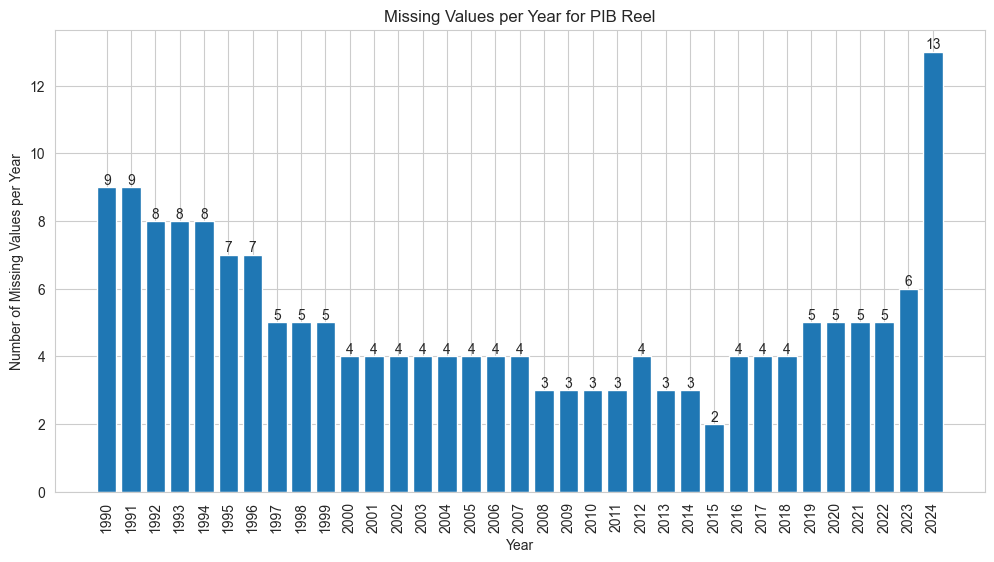

In [ ]:
dv.plot_missing_values_per_year(PIB_Reel_data,"PIB")

On remarque que la distribution des `NaN` est à peu près uniforme. On aurait pu conjecturer que autour des années 1990, il y aurait plus de `NaN` et que ce nombre diminuerait au fil du temps (grâce à la démocratisation des données). 

Mais ce n'est pas le cas ici. On remarque même un pic de données manquantes en 2024.

Essayons de voir un peu ce qui cloche en 2024 parce que c'est un phénomène étrange qu'il y ait autant de trous à une date aussi récente.

On examine donc dans la suite les pays qui ont des valeurs manquantes en 2024.

In [ ]:
NaN2024 = PIB_Reel_data[PIB_Reel_data["date"]==2024]["PIB"].isna()
NaN2024_countries = PIB_Reel_data[PIB_Reel_data["date"]==2024][NaN2024]
NaN2024_countries

,country,date,PIB
0,AFG,2024,NaN
910,BTN,2024,NaN
1820,ERI,2024,NaN
3360,LBN,2024,NaN
3500,LIE,2024,NaN
4830,PLW,2024,NaN
4935,PRK,2024,NaN
5425,SMR,2024,NaN
5530,SSD,2024,NaN
5810,SYR,2024,NaN


Une stratégie envisageable pour traiter les valeurs manquantes consiste à imputer ces données en utilisant la moyenne des valeurs observées au cours des années précédentes pour chaque pays. 

Mais, cette méthode ne peut être appliquée que pour les années intérieures, c’est-à-dire à partir de la première année pour laquelle une valeur non manquante est disponible.

Les périodes initiales présentant des données absentes ne peuvent pas être imputées de manière fiable selon cette approche. 

Mais avant de commencer l'imputation, analysons les données manquantes à la lumière du deuxième axe: celui des pays.

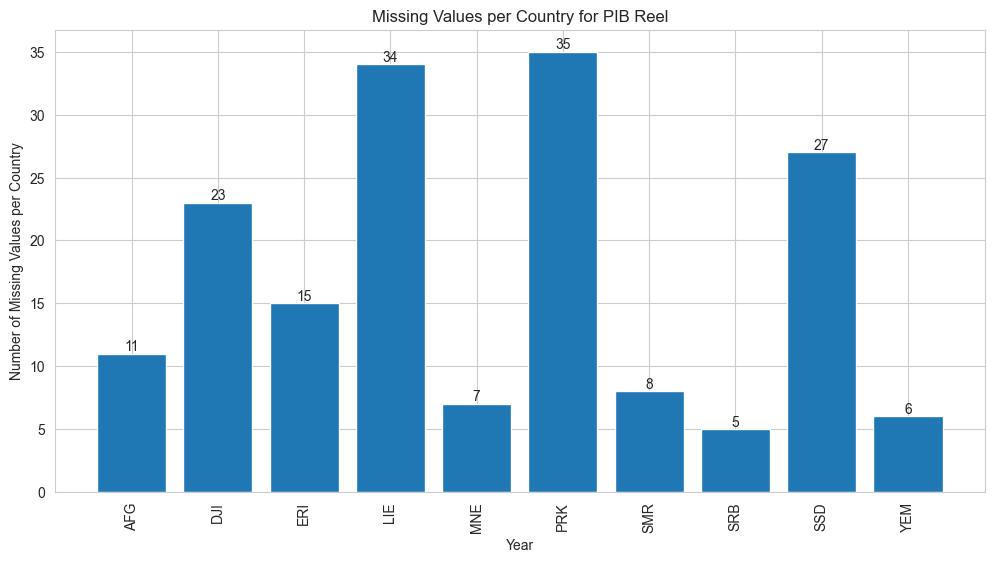

In [ ]:
# Missing data per countries
# On va mettre un treshold à 5 valeurs pour tolérer 10% de données manquantes sinon on vire le pays.
countries_toRemove = dv.plot_missing_values_per_country(PIB_Reel_data,"PIB",treshold=0.1)

indexes_toRemove = []
for country in countries_toRemove:
    country_indexes = PIB_Reel_data[PIB_Reel_data["country"]==country].index.tolist()
    indexes_toRemove.extend(country_indexes)

Nous avons filtré les pays avec un seuil à ***10%*** de valeurs manquantes par rapport au nombre total de valeurs possibles. Notons que ce choix de seuil était plutôt arbitraire.

Ce qu'on remarque en premier lieu c'est qu'il y a des pays qui ont la quasi-totalité de leurs informations qui sont manquantes. Cela suggère donc qu'il y a dû y avoir un problème avec les valeurs de ces pays dans les données récupérées au niveau de l'API. Nous décidonc donc d'enlever ces pays de la base de données. 

Etudions donc l'effet de l'éviction de ces pays sur les valeurs manquantes dans la base de données.

In [ ]:
da.check_missing_values(PIB_Reel_data,"PIB")

PIB_Reel_data_cleaned = PIB_Reel_data.drop(indexes_toRemove,axis='index')
PIB_Reel_data_cleaned.reset_index(drop=True,inplace=True)

da.check_missing_values(PIB_Reel_data_cleaned,"PIB")

Le dataframe contient des données temporelles relatives à 190 pays de 1990 à 2024.
Il y a 178 valeurs manquantes sur un total de 6755 dans la base de données.
Soit un ratio de 2.64% de valeurs manquantes dans la base de données.

Le dataframe contient des données temporelles relatives à 180 pays de 1990 à 2024.
Il y a 7 valeurs manquantes sur un total de 6405 dans la base de données.
Soit un ratio de 0.11% de valeurs manquantes dans la base de données.



Le résultat est poignant. On constate une imposante réduction du ratio de valeurs manquantes en partant de `2.64%` pour atteindre `0.11%`.

Maintenant nous allons pouvoir appliquer notre stratégie d'imputation sur les valeurs manquantes qui sont toujours présentes dans le dataframe.

Regardons d'abord où elles se trouvent.

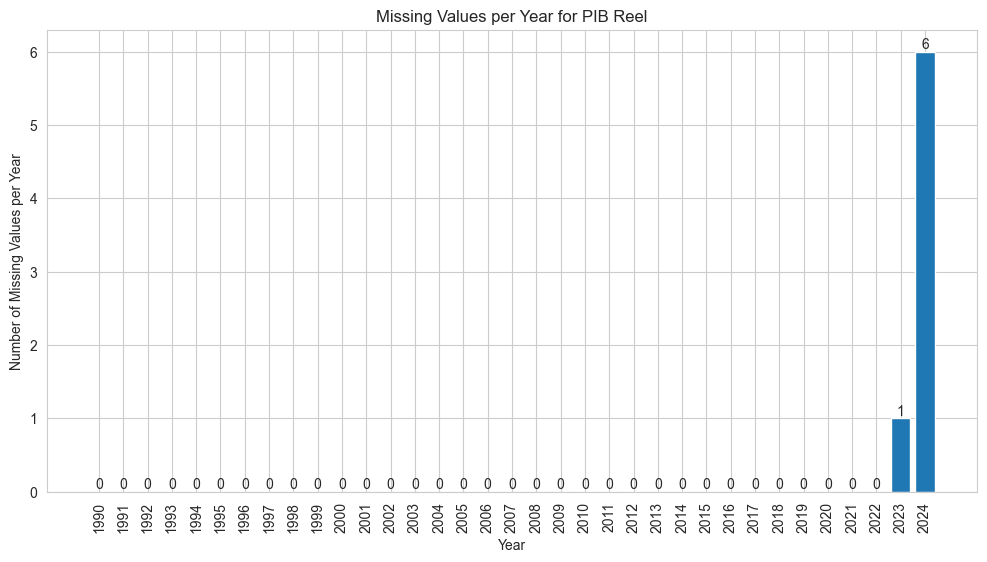

In [ ]:
dv.plot_missing_values_per_year(PIB_Reel_data_cleaned,"PIB")

On remarque maintenant que les valeurs manquantes sont rares et situées à la fin de la série temporelle. Il nous apparaît donc logique de remplir ces données manquantes avec la moyenne obtenues à partir de toutes les autres valeurs. Et c'est ce que nous faisons avec les fonctions qui suivent.

In [ ]:
PIB_Reel_data_final = da.impute_missing_values(PIB_Reel_data_cleaned,"PIB",method="mean")
da.check_missing_values(PIB_Reel_data_final,"PIB")
PIB_Reel_data_final

Le dataframe contient des données temporelles relatives à 180 pays de 1990 à 2024.
Il y a 0 valeurs manquantes sur un total de 6405 dans la base de données.
Soit un ratio de 0.00% de valeurs manquantes dans la base de données.



,country,date,PIB
0,AGO,2024,1.078033e+11
1,AGO,2023,1.032363e+11
2,AGO,2022,1.019483e+11
3,AGO,2021,9.782408e+10
4,AGO,2020,9.580944e+10
...,...,...,...
6400,ZWE,1994,1.776635e+10
6401,ZWE,1993,1.626430e+10
6402,ZWE,1992,1.609508e+10
6403,ZWE,1991,1.768993e+10


Grâce à cette méthode nous parvenons enfin à obtenir un dataframe propre qui nous permettra d'effectuer maintenant des analyses convenables.

### Evolution du PIB mondial

Tout d'abord, nous affichons une évolution du PIB mondial pour voir s'il est bien en accord avec le consensus général.

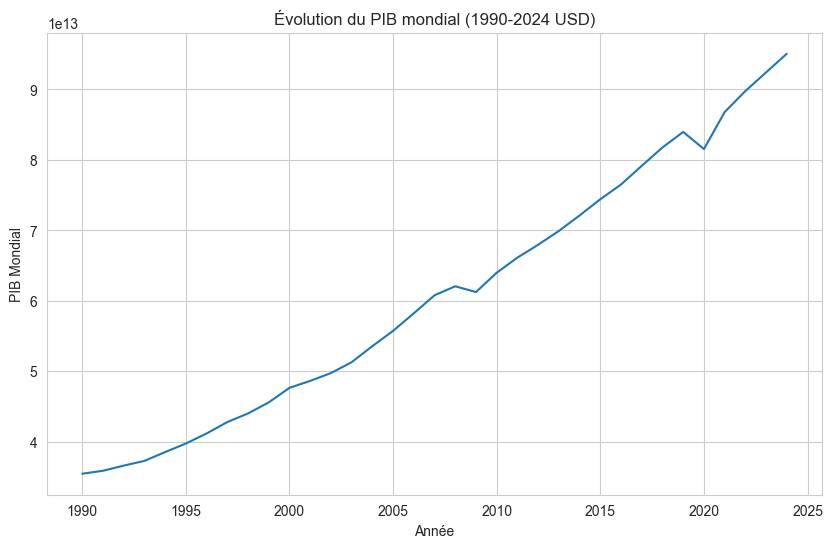

In [ ]:
dv.plot_world_PIB(PIB_Reel_data_final)

On observe ainsi la croissance du PIB mondial. Cette croissance présente une dynamique positive sur le long terme, mais parfois il peut y arriver des phases de ralentissement liées à des crises économiques, financières ou sanitaires. Il apparaît donc relativement important d'étudier ces scénarios de crise afin d’interpréter correctement les variations de la tendance de long terme.

### Analyse interquartiles

Observons ensuite les évolutions par quartiles des PIB réels. Le but de cette approche est de voir si certains pays se distinguent par rapport aux autres. Pour réaliser cela, nous utilisons une séparation en 20 quantiles car visuellement, c'est la valeur qui permet d'effectuer une séparation nette des trajectoires intéressantes.

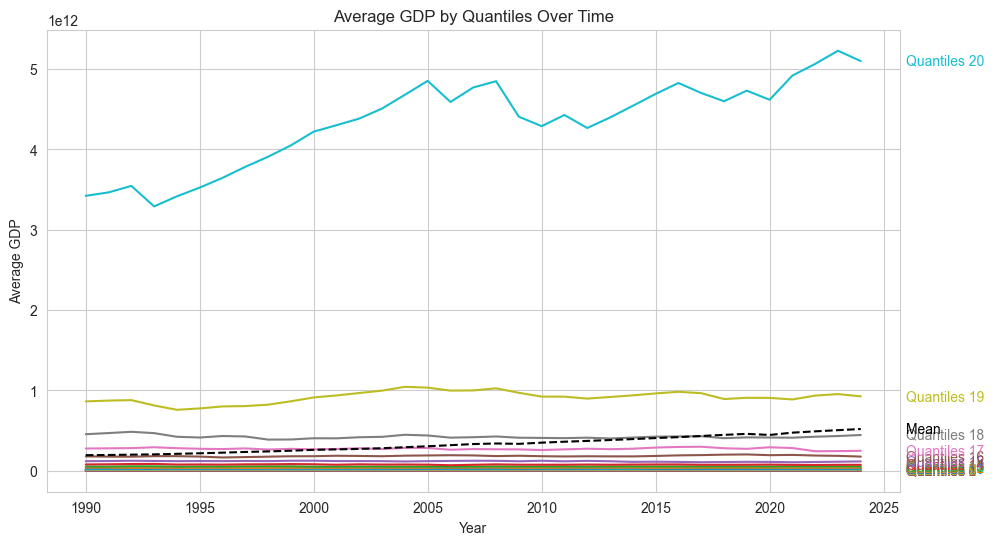

In [ ]:
dv.plot_PIB_quantile(PIB_Reel_data_final)

On observe des évolutions distinctes du PIB réel par pays, avec une majorité de pays affichant des progressions continues. Notamment on arrivent à identifier deux groupes de pays qui se distinguent des autres. Intéressons nous donc à ces pays.

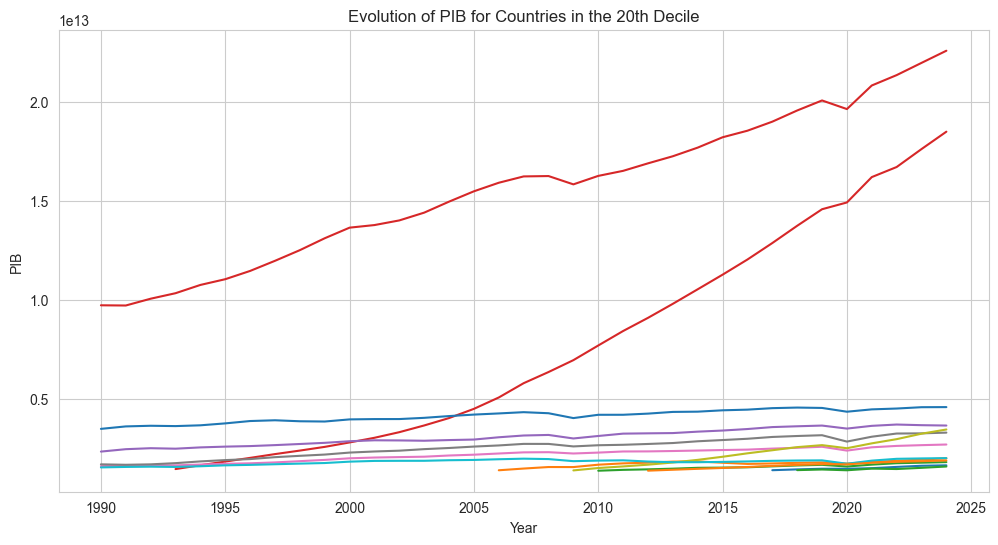

Countries in the 20th-decile: ['AUS' 'BRA' 'CAN' 'CHN' 'DEU' 'ESP' 'FRA' 'GBR' 'IND' 'ITA' 'JPN' 'KOR'
 'RUS' 'USA']


In [ ]:
dv.plot_PIB_top_quantile_countries(PIB_Reel_data_final)

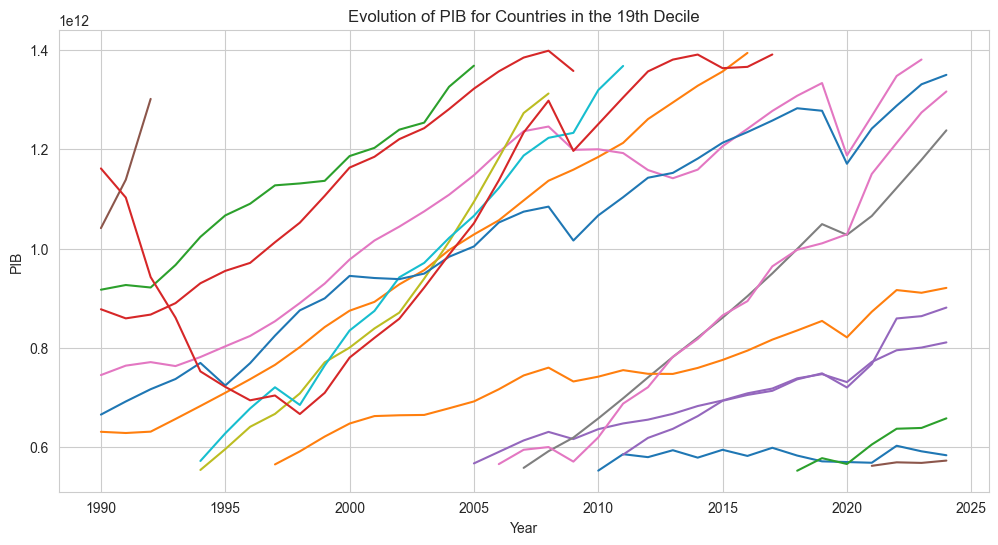

Countries in the 19th-decile: ['ARG' 'AUS' 'BRA' 'CAN' 'CHE' 'CHN' 'ESP' 'IDN' 'IND' 'KOR' 'MEX' 'NLD'
 'POL' 'RUS' 'SAU' 'SWE' 'TUR']


In [ ]:
dv.plot_PIB_top_quantile_countries(PIB_Reel_data_final,chosen_quantile=18)

On note que dans le quantile le plus élevé (le vingtième), on retrouve des pays à forte croissance ou à grande puissance économique, tels que la France, le Brésil, le Canada, la Chine, l’Allemagne, les États-Unis, etc. Ces pays présentent des trajectoires soutenues, caractérisées par des niveaux très élevés de production économique.

Le quantile immédiatement inférieur comprend également des pays majeurs comme l’Argentine, l’Espagne, l’Indonésie, l’Inde, la Corée du Sud, la Suède et la Turquie, etc. Bien que légèrement moins performants que ceux du décile supérieur, ces pays montrent néanmoins des trajectoires économiques robustes, ce qui reflète leur rôle important dans l’économie mondiale. 

Ce qu'on retient de cette classification par quantiles c'est qu'elle permet de retrouver des résultats qui sont connus et acceptés par tous. Les pays leaders en matière de PIB réel ont donc pu être identifiés et cela fait sens.

### Taille du pays dans l'économie mondiale

De ce qui précède, on note qu'on peut classifier les pays en termes de performances économiques. Pour faire cela, nous décidons d'introduire une nouvelle variable indicatrice de la taille d'un pays dans l'économie mondiale. Les fonctions suivantes permettent de réaliser cela en notant que la taille d'un pays est donnée en pourcentage par :

$Taille = \frac{PIB_{reel}}{PIB_{mondial}} \times 100$.


In [ ]:
dump = PIB_Reel_data_final.groupby(['country','date']).sum().apply(lambda x: 100*x/PIB_Reel_data_final.groupby("date")["PIB"].sum()).reset_index() # Associer à chaque pays son poids dans l'économie mondiale par année
dump.rename(columns={"PIB":"weightCountry"},inplace=True)
weightCountry = dump.groupby(['country']).mean()['weightCountry'].reset_index() 
weightCountry.rename(columns={"weightCountry":"avgWeightCountry"},inplace=True)

weightCountry.sort_values(by="avgWeightCountry",ascending=False)
dump

,country,date,weightCountry
0,AGO,1990,0.087706
1,AGO,1991,0.087539
2,AGO,1992,0.080791
3,AGO,1993,0.060304
4,AGO,1994,0.059127
...,...,...,...
6295,ZWE,2020,0.023444
6296,ZWE,2021,0.023894
6297,ZWE,2022,0.024516
6298,ZWE,2023,0.025087


On obtient donc le dataframe suivant qui nous montre que les USA sont largement puissants avec ***26.23%*** suivis de la Chine avec ***10.52%***.

### Clustering

Nous avons appliqué l'algorithme de k-means pour classifier les pays en fonction de leur PIB réel, en fixant le nombre de clusters à 4 de manière empirique. Cette valeur permet d’isoler visuellement les groupes les plus significatifs et d’éviter de regrouper des groupes trop proches. 

On peut intuitivement dire que les clusters identifiés correspondent à quatre catégories de performance économique : `Très Bas`, `Bas`, `Haut` et `Très Haut`.

En premier lieu, on affiche une classification des pays suivant les différentes années et ensuite on affiche une classification selon la performance moyenne affichée sur toutes les années.

In [ ]:
dv.animated_economicPower_map(dump)

In [ ]:
clusters_EconomicPower = dv.visualize_economicPower_clusters(weightCountry)

Nous pensons que mesurer le temps de reprise des pays après une crise constitue un outil pertinent pour évaluer la robustesse économique. En mesurant la durée nécessaire à un pays pour retrouver son niveau de production ou de PIB antérieur à la crise, il permet de comparer la capacité des différentes économies à absorber les chocs et à se stabiliser. 

Pour obtenir cet indicateur nous développons l'algorithme ci-dessous.

Cet algorithme calcule le temps moyen nécessaire pour qu'un pays retrouve son niveau de PIB après un pic économique, c’est-à-dire après avoir atteint un maximum local. Il identifie d’abord les pics locaux dans la série temporelle du PIB, puis mesure, pour chaque pic, le nombre d’années nécessaires pour que le PIB dépasse à nouveau ce niveau. 

Enfin, il calcule la moyenne de ces durées, fournissant un indicateur grossier de la rapidité de reprise d’un pays après des ralentissements ou des crises.

In [ ]:
def peak_to_breach_times(df_country):

    # Ordonner le dataframe pour que les séries temporelles commencent avec des dates croissantes
    df = df_country.sort_values('date').reset_index(drop=True).copy()
    
    df['prev_pib'] = df['PIB'].shift(1)
    df['next_pib'] = df['PIB'].shift(-1)
    df['is_peak'] = (df['PIB'] > df['prev_pib']) & (df['PIB'] > df['next_pib']) # Identifier les pics locaux i.e les années où le PIB est plus élevé que l'année précédente et l'année suivante
    
    peak_indices = df.index[df['is_peak']].tolist()
    
    times = []
    
    for i in peak_indices:
        peak_year = df.loc[i, 'date']
        peak_val = df.loc[i, 'PIB']
        
        # données survenues après le pic
        after_thePeak = df.loc[i+1:].copy()
        if after_thePeak.empty:
            continue
        
        # Si aucune valeur dans la suite n'est inférieure au pic, on continue parce que ça veut dire qu'il n'y a pas eu de crise après ce pic 
        if not (after_thePeak['PIB'] < peak_val).any():
            continue
        
        # Sinon on cherche la première année où le PIB dépasse le pic pour signaler un retour à la normale
        breached = after_thePeak[after_thePeak['PIB'] > peak_val]
        if breached.empty:
            continue
        
        breach_year = breached['date'].iloc[0]
        time_to_breach = breach_year - peak_year
        times.append(time_to_breach)
    
    mean_time = np.mean(times) if len(times) > 0 else np.nan # Permet de calculer un cas moyen
    return mean_time


responseTime_data = pd.DataFrame(PIB_Reel_data_final.groupby('country')[['date','PIB']].apply(lambda x:peak_to_breach_times(x)))
responseTime_data.rename(columns={0:"avgResponseTime"},inplace=True)
responseTime_data.reset_index(inplace=True)

responseTime_data.sort_values(by="avgResponseTime",ascending=False)

,country,avgResponseTime
34,COD,11.000000
179,ZWE,10.750000
77,ITA,8.000000
2,AND,7.333333
0,AGO,7.000000
...,...,...
166,TZA,NaN
167,UGA,NaN
168,UKR,NaN
171,UZB,NaN


Nous remarquons de fait qu'il y a des valeurs manquantes pour certains pays. Cela se traduit probablement par le fait que sur les séries temporelles relatives à certains pays, il n'y a pas assez de fluctuations ce qui ne permet pas de récupérer des temps de réponses aux crises. 

Analysons plus en profondeur la répartition de ces valeurs manquantes.

In [ ]:
da.check_missing_values(responseTime_data,"avgResponseTime")

Il y a 17 valeurs manquantes sur un total de 180 dans la base de données.
Soit un ratio de 9.44% de valeurs manquantes dans la base de données.



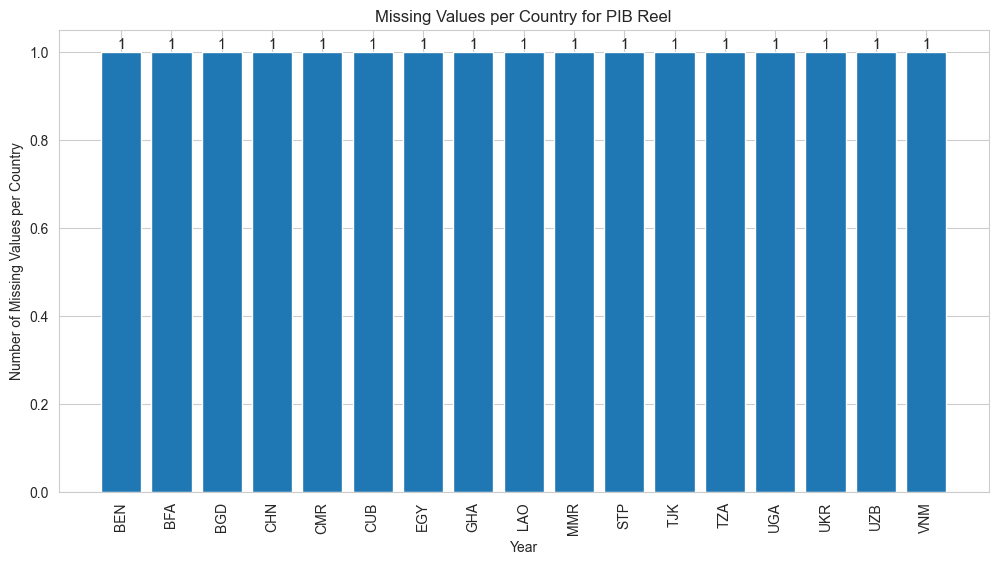

Index(['BEN', 'BFA', 'BGD', 'CHN', 'CMR', 'CUB', 'EGY', 'GHA', 'LAO', 'MMR',
       'STP', 'TJK', 'TZA', 'UGA', 'UKR', 'UZB', 'VNM'],
      dtype='object', name='country')

In [ ]:
dv.plot_missing_values_per_country(responseTime_data,"avgResponseTime",treshold=0)

Certains des pays n'ont pas obtenu de temps de réponse avec notre algorithme. On pourrait modéliser en disant qu'ils ont un temps infiniment long ou juste prendre des valeurs arbitrairement grandes. Mais par souci de simplicité et de non penchant à faire des hypothèses fallacieuses, nous allons les sortir de la base de données et réaliser des études sur les pays qui ont un temps de réponse à des scénarios de crises.

In [ ]:
responseTime_data.dropna(inplace=True)
responseTime_data.reset_index(drop=True,inplace=True)
responseTime_data

,country,avgResponseTime
0,AGO,7.000000
1,ALB,2.500000
2,AND,7.333333
3,ARE,2.666667
4,ARG,3.142857
...,...,...
158,VUT,4.500000
159,WSM,2.800000
160,ZAF,2.500000
161,ZMB,2.666667


## 4. Importations et exportations

L’étude des flux commerciaux internationaux offre un aperçu essentiel de la structure économique d’un pays et de sa capacité à absorber les chocs financiers. En effet, les importations et exportations reflètent la position d’un pays dans l’économie mondiale et sa dépendance vis-à-vis des marchés extérieurs.

Une balance commerciale excédentaire ou un ratio export/import élevé peuvent indiquer une économie plus autonome et robuste, tandis qu’un déficit chronique peut signaler une vulnérabilité accrue face aux crises externes. De plus, la diversité des échanges et l’ouverture commerciale contribuent à la flexibilité des pays et à leur capacité à réagir rapidement aux perturbations économiques.

Tout d’abord, nous avons commencé par récupérer les données relatives aux flux commerciaux pour l’ensemble des pays du monde, sur la période 1990-2024, en distinguant importations et exportations. Ces données sont harmonisées à l’aide des codes ISO-3 afin d’assurer une correspondance précise entre les pays et leurs séries temporelles.

Les DataFrames obtenus présentent ainsi une structure uniforme : chaque ligne correspond à un pays pour une année donnée, avec les valeurs d’importations et d’exportations. Les premières lignes montrent que certaines valeurs peuvent être manquantes, notamment pour les années les plus récentes ou pour certains pays où les données sont incomplètes.

In [ ]:
wb = dc.WorldBankData()

liste_pays = codesISO_data["ISO-3"].tolist()
importations_data = wb.get_indicator("Importations", liste_pays, start=1990, end=2024)
exportations_data = wb.get_indicator("Exportations", liste_pays, start=1990, end=2024)

# Remplacer les noms des pays par leurs codes ISO dans les deux datasets
importations_data["country"] = importations_data['country'].apply(lambda x: finalMatchingDictionnary[x] if x in finalMatchingDictionnary.keys() else x)
exportations_data["country"] = exportations_data['country'].apply(lambda x: finalMatchingDictionnary[x] if x in finalMatchingDictionnary.keys() else x)

importations_data

,country,date,Importations
0,AFG,2024,NaN
1,AFG,2023,50.731877
2,AFG,2022,54.505427
3,AFG,2021,37.069564
4,AFG,2020,36.289077
...,...,...,...
6750,ZWE,1994,36.519563
6751,ZWE,1993,32.448894
6752,ZWE,1992,36.484086
6753,ZWE,1991,27.168633


In [ ]:
exportations_data

,country,date,Exportations
0,AFG,2024,NaN
1,AFG,2023,16.852788
2,AFG,2022,18.380042
3,AFG,2021,14.342153
4,AFG,2020,10.420817
...,...,...,...
6750,ZWE,1994,34.601298
6751,ZWE,1993,30.720621
6752,ZWE,1992,27.227979
6753,ZWE,1991,23.883877


Avant de procéder à toute analyse approfondie, il est essentiel d’évaluer la complétude des séries temporelles relatives aux importations et exportations. Le dataset couvre 187 pays pour la période allant de 1990 à 2024.

Une inspection des données révèle 1 232 valeurs manquantes sur un total de 6 755 observations, soit un ratio de 18,24 % de données absentes. Cette proportion est significative et justifie une attention particulière afin de ne pas biaiser les analyses ultérieures.

In [ ]:
da.check_missing_values(importations_data,"Importations")
da.check_missing_values(exportations_data,"Exportations")

Le dataframe contient des données temporelles relatives à 190 pays de 1990 à 2024.
Il y a 1232 valeurs manquantes sur un total de 6755 dans la base de données.
Soit un ratio de 18.24% de valeurs manquantes dans la base de données.

Le dataframe contient des données temporelles relatives à 190 pays de 1990 à 2024.
Il y a 1232 valeurs manquantes sur un total de 6755 dans la base de données.
Soit un ratio de 18.24% de valeurs manquantes dans la base de données.



Nous visualisons ensuite la répartition des valeurs manquantes par année. Cette approche permet de détecter des périodes où la couverture des données est plus faible, ce qui pourrait correspondre à des lacunes dans les statistiques nationales ou des retards de collecte. Les graphiques mettent en évidence que certaines années présentent davantage de données manquantes, ce qui pourrait influencer la précision des calculs d’indicateurs annuels. 

Nous observons ici qu'il y a systématiquement autant de valeurs manquantes par année pour les exportations que pour les importations ce qui est loin d'être surprenant et pouvons également relever une tendance à la baisse des valeurs manquantes au cours du temps, sûrement dû à une amélioration du système de collecte de données avec l'avancée technologique. L’année 2024, quant à elle, présente étonnamment un nombre plus élevé de valeurs manquantes par rapport aux années précédentes, avec 43 entrées manquantes. 

Cette hausse s’explique principalement par le décalage naturel de publication des données économiques récentes : les statistiques pour l’année la plus récente ne sont pas encore complètement consolidées ni validées par les institutions nationales et internationales. Certaines valeurs disponibles ne sont que des estimations partielles et certaines publications sont encore en attente, ce qui crée cette augmentation apparente des données manquantes.

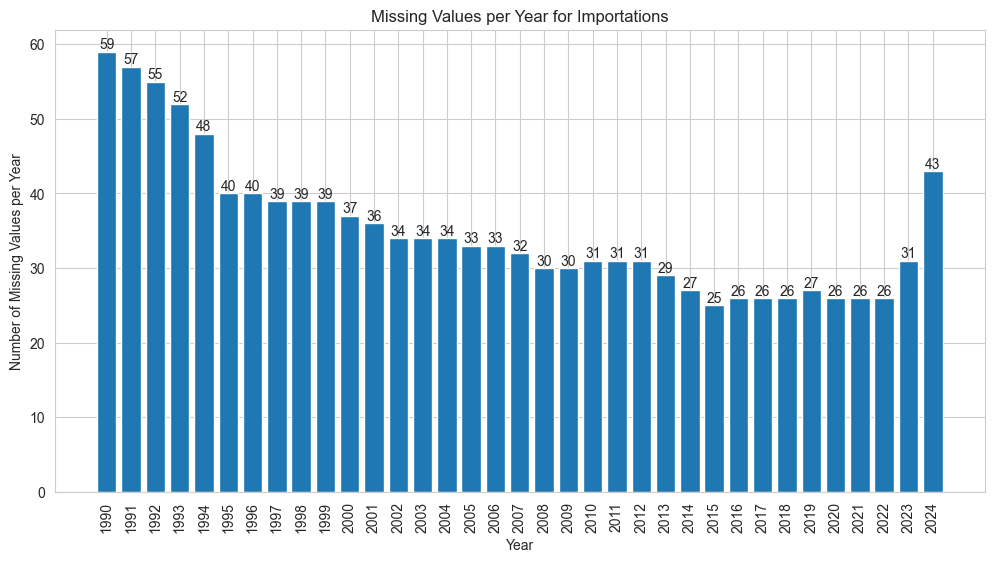

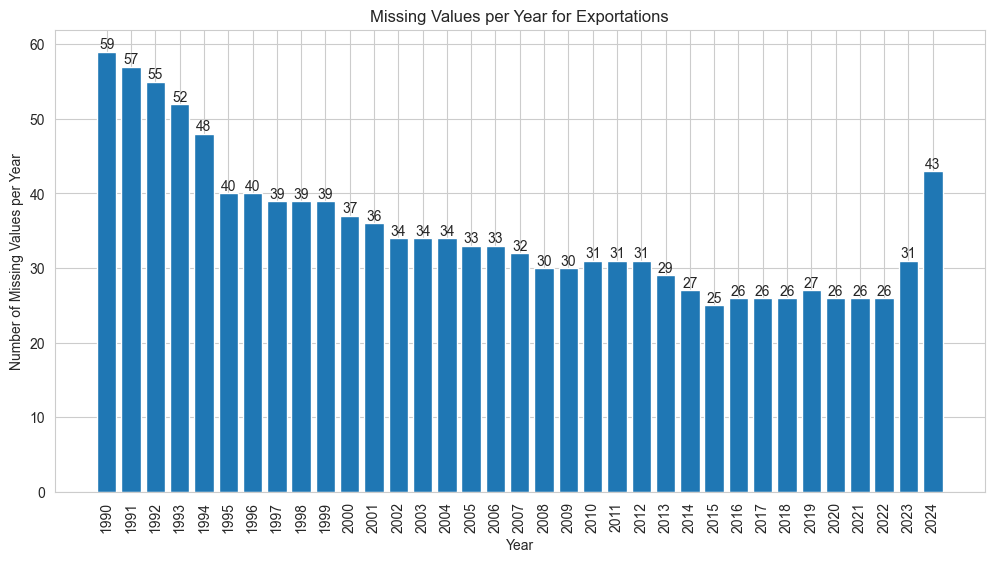

In [ ]:
dv.plot_missing_values_per_year(importations_data,"Importations",text="Importations")
dv.plot_missing_values_per_year(exportations_data,"Exportations",text="Exportations")

Après avoir récupéré les séries temporelles pour 187 pays de 1990 à 2024, nous avons observé qu’un certain nombre de pays présentaient des données manquantes de manière significative. Plutôt que de tenter d’imputer des valeurs pour ces pays très lacunaires, ce qui aurait pu introduire des biais, nous avons choisi de les exclure du jeu de données.

Pour cela, nous avons défini un seuil de 10% de valeurs manquantes par pays. Les pays dépassant ce seuil ont été identifiés et leurs séries retirées des datasets. Cette étape permet de conserver uniquement des séries suffisamment complètes pour réaliser des analyses fiables.

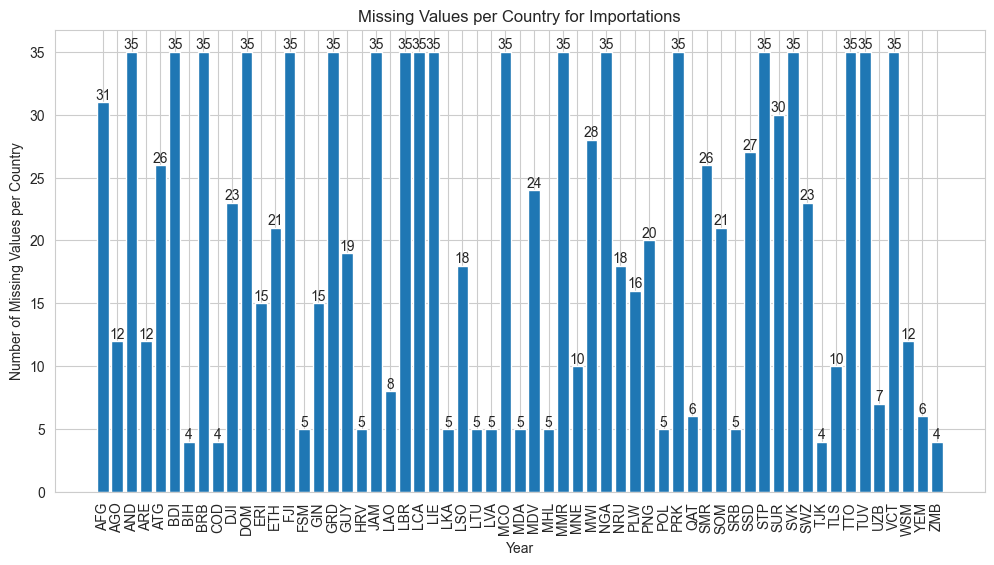

In [ ]:
countries_toRemoveImportations = dv.plot_missing_values_per_country(importations_data,"Importations",treshold=0.1,text="Importations")

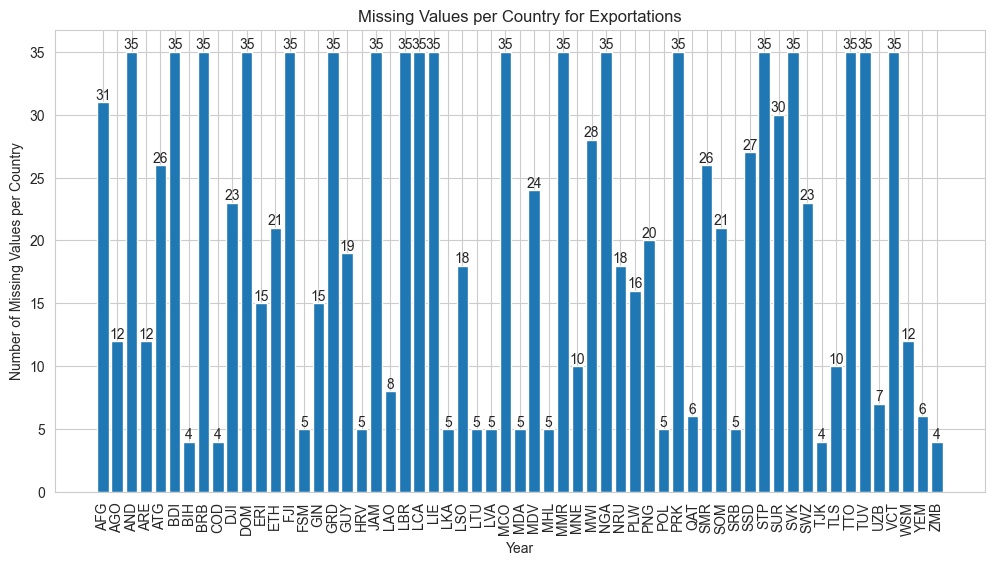

In [ ]:
countries_toRemoveExportations = dv.plot_missing_values_per_country(exportations_data,"Exportations",treshold=0.1,text="Exportations")

Après cette opération, le nombre de pays inclus dans l’étude est passé de 187 à 129, et le taux de valeurs manquantes a été réduit à moins de 0,5%. Cette homogénéisation des données garantit que les indicateurs que nous calculerons par la suite seront robustes et comparables d’un pays à l’autre.

Cette démarche s’inscrit dans notre problématique générale : comprendre la vitesse de réponse des pays aux crises financières et identifier les facteurs structurels qui influencent cette capacité de résilience. En travaillant sur des séries fiables et continues, nous pouvons désormais examiner avec précision comment les flux commerciaux se comportent avant, pendant et après des épisodes de crise, et comparer les trajectoires des pays de manière pertinente.

In [ ]:
indexes_toRemoveImports = []
indexes_toRemoveExports = []

for country in countries_toRemoveImportations:
    country_indexes = importations_data[importations_data["country"]==country].index.tolist()
    indexes_toRemove.extend(country_indexes)

for country in countries_toRemoveExportations:
    country_indexes = exportations_data[exportations_data["country"]==country].index.tolist()
    indexes_toRemoveExports.extend(country_indexes)

In [ ]:
da.check_missing_values(importations_data,"Importations")

importations_data = importations_data.drop(indexes_toRemove,axis='index')
importations_data.reset_index(drop=True,inplace=True)

print("\n")
da.check_missing_values(importations_data,"Importations")

Le dataframe contient des données temporelles relatives à 190 pays de 1990 à 2024.
Il y a 1232 valeurs manquantes sur un total de 6755 dans la base de données.
Soit un ratio de 18.24% de valeurs manquantes dans la base de données.



Le dataframe contient des données temporelles relatives à 131 pays de 1990 à 2024.
Il y a 22 valeurs manquantes sur un total de 4585 dans la base de données.
Soit un ratio de 0.48% de valeurs manquantes dans la base de données.



In [ ]:
da.check_missing_values(exportations_data,"Exportations")

exportations_data = exportations_data.drop(indexes_toRemove,axis='index')
exportations_data.reset_index(drop=True,inplace=True)

print("\n")
da.check_missing_values(exportations_data,"Exportations")

Le dataframe contient des données temporelles relatives à 190 pays de 1990 à 2024.
Il y a 1232 valeurs manquantes sur un total de 6755 dans la base de données.
Soit un ratio de 18.24% de valeurs manquantes dans la base de données.



Le dataframe contient des données temporelles relatives à 131 pays de 1990 à 2024.
Il y a 22 valeurs manquantes sur un total de 4585 dans la base de données.
Soit un ratio de 0.48% de valeurs manquantes dans la base de données.



Après avoir retiré les pays présentant trop de données manquantes, il subsistait encore quelques lacunes, principalement concentrées sur les années les plus récentes ou les plus anciennes. Ces absences sont compréhensibles, car elles résultent comme nous l'avons dit plus tôt soit d’une indisponibilité historique des données pour les périodes anciennes, soit, pour les années récentes, du temps nécessaire aux sources statistiques pour publier et valider les chiffres les plus récents.

Pour garantir la continuité des séries temporelles et permettre un calcul fiable des indicateurs commerciaux, nous avons procédé à une imputation des valeurs manquantes. La méthode choisie combine un backward fill et un forward fill, ce qui permet de remplir les cases vides en utilisant les valeurs précédentes ou suivantes disponibles. Cette approche est simple, cohérente et évite d’introduire des biais trop importants, tout en respectant les tendances observées dans les données historiques.

Après cette opération, l’ensemble des séries pour les 129 pays retenus est désormais complet, sans aucune valeur manquante. Le ratio de données manquantes est ainsi ramené à 0%, ce qui garantit que tous les indicateurs dérivés calculés par la suite seront fiables et comparables sur l’ensemble de la période 1990‑2024.

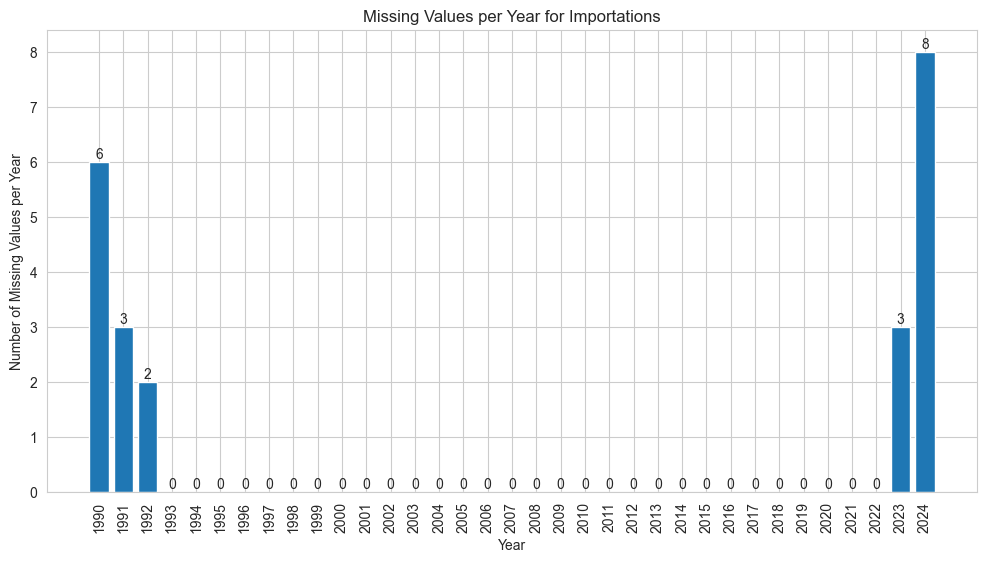

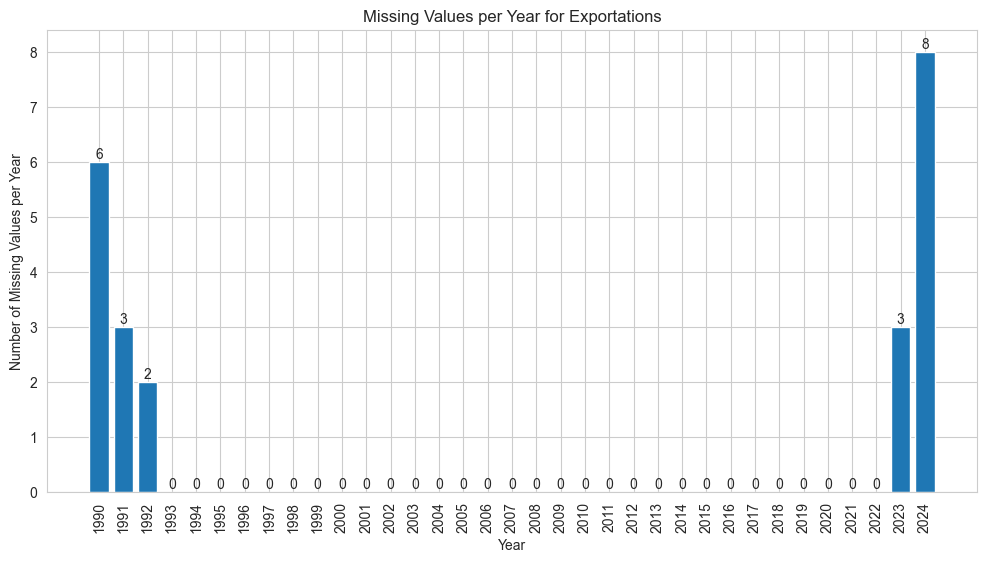

In [ ]:
dv.plot_missing_values_per_year(importations_data,"Importations",text="Importations")
dv.plot_missing_values_per_year(exportations_data,"Exportations",text="Exportations")

In [ ]:
importations_data = da.impute_missing_values(importations_data,"Importations",method="backward_fill")
importations_data = da.impute_missing_values(importations_data,"Importations",method="forward_fill")
da.check_missing_values(importations_data,"Importations")

Le dataframe contient des données temporelles relatives à 131 pays de 1990 à 2024.
Il y a 0 valeurs manquantes sur un total de 4585 dans la base de données.
Soit un ratio de 0.00% de valeurs manquantes dans la base de données.



In [ ]:
exportations_data = da.impute_missing_values(exportations_data,"Exportations",method="backward_fill")
exportations_data = da.impute_missing_values(exportations_data,"Exportations",method="forward_fill")
da.check_missing_values(exportations_data,"Exportations")

Le dataframe contient des données temporelles relatives à 131 pays de 1990 à 2024.
Il y a 0 valeurs manquantes sur un total de 4585 dans la base de données.
Soit un ratio de 0.00% de valeurs manquantes dans la base de données.



Une fois cette étape de nettoyage réalisée, nous avons fusionné les deux jeux de données afin d’obtenir un cadre complet pour l’analyse des flux commerciaux. Chaque ligne du tableau représente ainsi un pays pour une année donnée, avec ses volumes d’importations et d’exportations correspondants.

**NOTE : Toutes les valeurs présentées dans cette section sont exprimées en pourcentage du PIB, ce qui permet de comparer les importations, exportations et soldes commerciaux indépendamment de la taille absolue des économies.**

In [ ]:
trade_data = pd.merge(importations_data,exportations_data,on=['country','date'])
trade_data

,country,date,Importations,Exportations
0,ALB,2024,43.169768,36.284869
1,ALB,2023,43.933672,38.418821
2,ALB,2022,47.500968,37.197076
3,ALB,2021,44.457348,31.133056
4,ALB,2020,36.979941,22.540759
...,...,...,...,...
4580,ZWE,1994,36.519563,34.601298
4581,ZWE,1993,32.448894,30.720621
4582,ZWE,1992,36.484086,27.227979
4583,ZWE,1991,27.168633,23.883877


In [ ]:
trade_analyzer = da.TradeDataAnalyzer(trade_data=trade_data)
trade_analyzer.trade_data

,country,date,Importations,Exportations
0,ALB,2024,43.169768,36.284869
1,ALB,2023,43.933672,38.418821
2,ALB,2022,47.500968,37.197076
3,ALB,2021,44.457348,31.133056
4,ALB,2020,36.979941,22.540759
...,...,...,...,...
4580,ZWE,1994,36.519563,34.601298
4581,ZWE,1993,32.448894,30.720621
4582,ZWE,1992,36.484086,27.227979
4583,ZWE,1991,27.168633,23.883877


Afin de mieux comprendre la position commerciale de chaque pays, nous avons calculé la balance commerciale, définie comme la différence entre les exportations et les importations. Une valeur positive indique que le pays est un exportateur net, tandis qu’une valeur négative signale un importateur net. Cette approche permet de visualiser rapidement les pays qui contribuent le plus aux flux commerciaux mondiaux chaque année et ceux qui en dépendent davantage pour leurs importations.

In [ ]:
trade_analyzer.get_balance()
trade_analyzer.trade_data

,country,date,Importations,Exportations,commBalance
0,ALB,2024,43.169768,36.284869,-6.884899
1,ALB,2023,43.933672,38.418821,-5.514851
2,ALB,2022,47.500968,37.197076,-10.303892
3,ALB,2021,44.457348,31.133056,-13.324292
4,ALB,2020,36.979941,22.540759,-14.439182
...,...,...,...,...,...
4580,ZWE,1994,36.519563,34.601298,-1.918265
4581,ZWE,1993,32.448894,30.720621,-1.728273
4582,ZWE,1992,36.484086,27.227979,-9.256107
4583,ZWE,1991,27.168633,23.883877,-3.284756


Nous commençons par examiner les caractéristiques générales des flux commerciaux à l’échelle mondiale, en nous appuyant sur les données consolidées d’importations, d’exportations et de balance commerciale pour l’ensemble des pays retenus.

Les importations présentent une moyenne de **41,92%**, avec des écarts significatifs entre pays (écart-type de **24,01%**). Certaines économies montrent des volumes très modestes, proches de zéro, tandis que d’autres atteignent des valeurs supérieures à 200, illustrant la diversité des capacités d’approvisionnement et la taille des marchés nationaux.

Les exportations, quant à elles, sont légèrement inférieures en moyenne (**38,06%**), mais leur dispersion est encore plus marquée (écart-type de **27,08%**), et certains pays dépassent largement les **200%** de leur PIB, traduisant une forte hétérogénéité dans la capacité à produire et à vendre sur les marchés internationaux.

La balance commerciale moyenne est négative (**-3,86%**), indiquant que, globalement, les importations excèdent légèrement les exportations dans l’échantillon. Toutefois, cette valeur moyenne masque des différences importantes entre pays : la majorité des pays se situent autour d’un déficit ou d’un léger excédent, mais quelques-uns affichent des déséquilibres très prononcés, allant jusqu’à **-108,81%** pour le déficit et **48,45%** pour l’excédent.

L’analyse des quartiles renforce cette impression de disparité : la moitié des pays importent entre **26,16%** et **53,14%** de leur PIB, exportent entre **20,66%** et **47,59%**, et présentent des balances commerciales comprises entre **-10,09%** et **3,07%**. Ces observations soulignent la diversité structurelle des économies, un facteur crucial pour comprendre leur vulnérabilité et leur capacité de réponse face aux crises financières et aux chocs externes.

In [ ]:
# Statistiques globales des importations, exportations et balance commerciale
trade_data[['Importations', 'Exportations', 'commBalance']].describe()

,Importations,Exportations,commBalance
count,4585.000000,4585.000000,4585.000000
mean,41.847565,38.065381,-3.782183
std,24.046865,27.076769,14.778086
min,0.015622,0.005377,-108.808876
25%,25.954223,20.654482,-9.988829
50%,34.904541,31.455728,-2.067400
75%,53.114125,47.593592,3.075999
max,208.332944,228.993771,48.452239


Pour comprendre davantage la structure des échanges internationaux, nous avons représenté la distribution des importations, exportations et balances commerciales pour l’ensemble des pays de la base de données.

L’histogramme des importations montre que la majorité des pays ont des flux modérés, mais quelques pays présentent des importations très élevées, ce qui reflète l’existence d’économies fortement intégrées au commerce mondial.

L’histogramme des exportations révèle une distribution similaire, avec une concentration de pays autour de valeurs moyennes, et quelques outliers à très forte capacité exportatrice.

Enfin, l’histogramme de la balance commerciale met en évidence que la plupart des pays se situent autour d’un léger déficit ou excédent, tandis que certains pays affichent des déséquilibres commerciaux très prononcés, positifs ou négatifs.

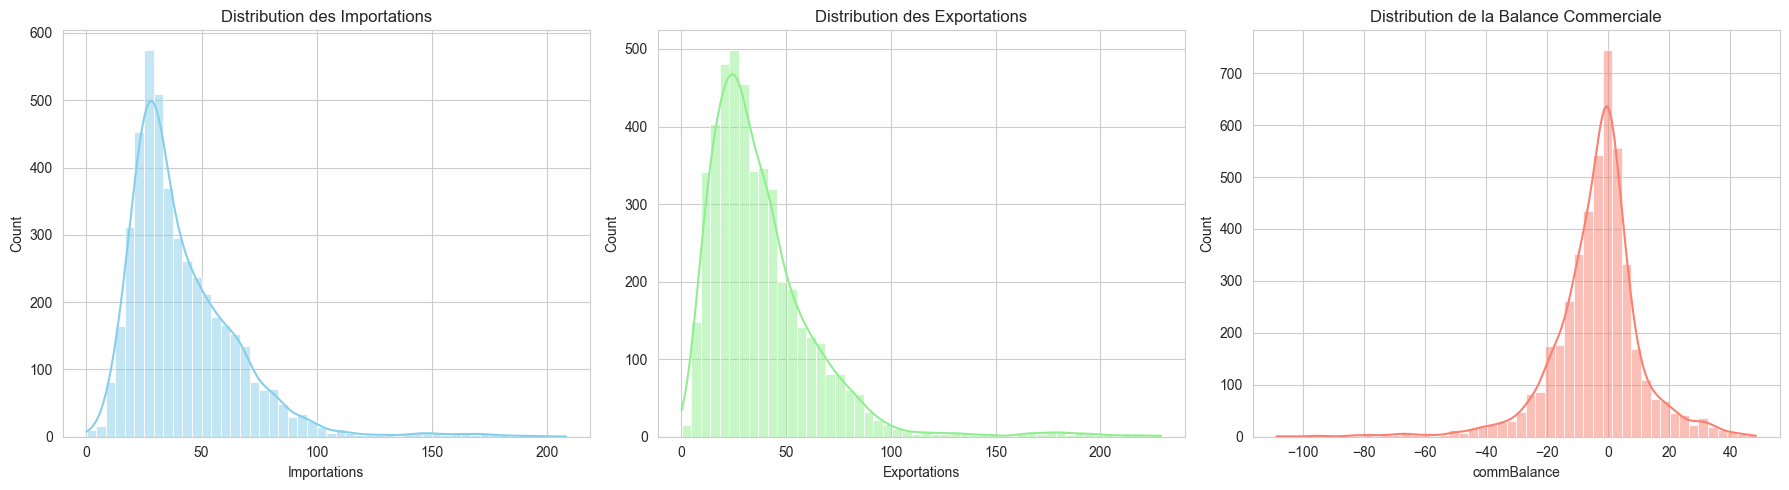

In [ ]:
# Histogrammes des importations, exportations et balances commerciales
fig, axes = plt.subplots(1, 3, figsize=(18,5))

sns.histplot(trade_data['Importations'], bins=50, ax=axes[0], kde=True, color='skyblue')
axes[0].set_title("Distribution des Importations")

sns.histplot(trade_data['Exportations'], bins=50, ax=axes[1], kde=True, color='lightgreen')
axes[1].set_title("Distribution des Exportations")

sns.histplot(trade_data['commBalance'], bins=50, ax=axes[2], kde=True, color='salmon')
axes[2].set_title("Distribution de la Balance Commerciale")

plt.tight_layout()
plt.show()

L’examen de la balance commerciale moyenne permet de distinguer deux groupes de pays aux trajectoires économiques opposées.

**Top 10 exportateurs nets :**
On remarque que le Luxembourg, le Gabon et Singapour occupent les premières places avec des balances commerciales moyennes très positives, supérieures à **23%** du PIB. Ces pays affichent une capacité d’exportation nettement supérieure à leurs importations, ce qui reflète soit une spécialisation forte dans certains secteurs exportateurs, soit une économie relativement ouverte et compétitive à l’international. D’autres pays de ce top 10, tels que Brunei, l’Irlande ou l’Arabie Saoudite, présentent également des excédents commerciaux significatifs, souvent liés à des ressources naturelles ou à des positions stratégiques dans le commerce mondial.

**Top 10 importateurs nets :**
À l’inverse, certains pays présentent des déficits commerciaux soutenus. L’Armenie, la Guinée-Bissau et l’Albanie sont les moins favorisés, avec des balances largement négatives, allant jusqu’à **-74%** du PIB pour Kiribati. Ces déficits reflètent des économies plus dépendantes des importations pour leur consommation ou leur production, ou encore des structures économiques moins orientées vers l’exportation. Le constat est particulièrement marqué pour des petites économies insulaires ou des pays à faible diversification industrielle.

In [ ]:
# Calcul de la balance moyenne
balance_avg = trade_data.groupby('country')['commBalance'].mean().sort_values(ascending=False)

# Top 10 exportateurs nets
top10 = balance_avg.head(10).reset_index()
top10 = top10.merge(codesISO_data[['Pays','ISO-3']], left_on='country', right_on='ISO-3', how='left')
top10 = top10[['Pays','commBalance']].rename(columns={'Pays':'country_name'})
top10.index = range(1, len(top10)+1)  
print("Top 10 pays exportateurs nets :")
display(top10)

# Top 10 importateurs nets (flop)
flop10 = balance_avg.tail(10).reset_index()
flop10 = flop10.merge(codesISO_data[['Pays','ISO-3']], left_on='country', right_on='ISO-3', how='left')
flop10 = flop10[['Pays','commBalance']].rename(columns={'Pays':'country_name'})
flop10.index = range(1, len(flop10)+1)  
print("\nTop 10 pays importateurs nets :")
display(flop10)

Top 10 pays exportateurs nets :


,country_name,commBalance
1,Luxembourg,25.985188
2,Gabon,25.591329
3,Singapore,23.709145
4,Brunei Darussalam[i],18.756416
5,Ireland,17.019870
6,Kuwait,15.234770
7,Oman,14.586263
8,Libya,13.565321
9,Bahrain,13.220006
10,Saudi Arabia,12.904544



Top 10 pays importateurs nets :


,country_name,commBalance
1,Haiti,-19.212775
2,Armenia,-19.229128
3,Albania,-21.712002
4,Jordan,-23.864737
5,Kyrgyzstan,-24.926637
6,Mozambique,-27.658703
7,Cabo Verde[j],-27.865427
8,Lebanon,-33.480745
9,Tonga,-39.439085
10,Kiribati,-74.080769


Pour des soucis de lisibilité, nous avons sélectionné les 5 pays avec les plus forts excédents commerciaux (**Top 5 exportateurs nets**) et les 5 pays avec les plus forts déficits commerciaux (**Flop 5 importateurs nets**). L’objectif était de visualiser l’évolution de leur balance commerciale au fil du temps et d’identifier les tendances générales pour les pays les plus performants et les plus dépendants du commerce extérieur.

On observe clairement deux dynamiques distinctes. Du côté des Top 5 exportateurs nets, les courbes restent généralement au-dessus de zéro, ce qui signifie que ces pays ont un excédent commercial régulier. Certains pays peuvent avoir des variations légères selon les années, mais la tendance générale reste positive, montrant une certaine stabilité économique et un rôle important dans le commerce international.

À l’inverse, les Flop 5 importateurs nets présentent des courbes systématiquement négatives. Cela reflète des déficits commerciaux persistants : ces pays dépendent des importations pour répondre à leurs besoins, ce qui peut être le signe d’une production locale plus faible ou d’une forte consommation de biens étrangers. On remarque parfois des pics ou des creux importants, ce qui pourrait correspondre à des crises économiques, à des fluctuations des prix mondiaux ou à des changements dans les politiques commerciales.

En comparant les deux groupes, la disparité est frappante. Les Top 5 dominent le commerce mondial sur la période étudiée, alors que les Flop 5 subissent une pression économique plus forte. Cette visualisation permet aussi de voir que la balance commerciale n’est pas statique : certains pays peuvent améliorer ou détériorer leur position au fil des années, et ces tendances peuvent être analysées pour comprendre les stratégies économiques, les chocs externes ou les dépendances spécifiques

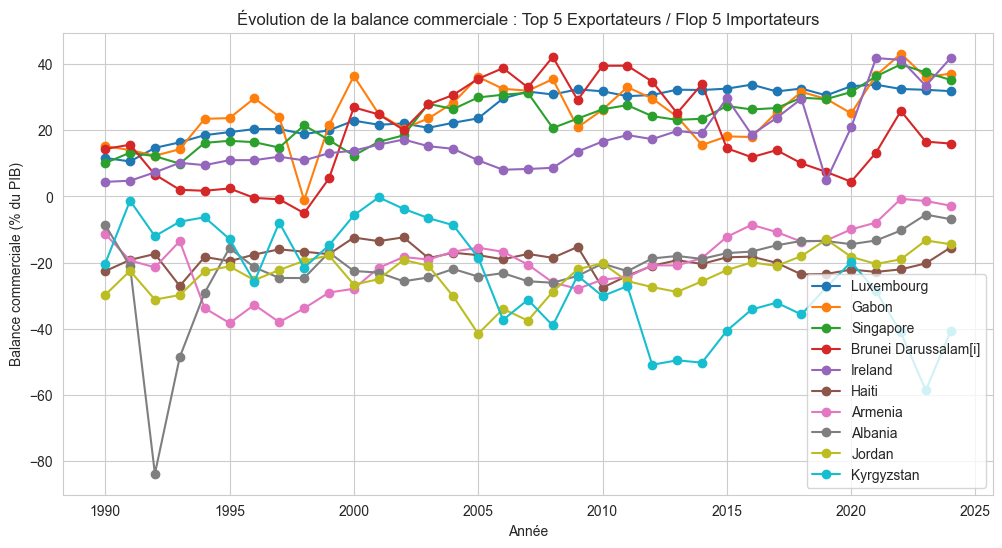

In [ ]:
# Top 5 exportateurs nets
top5 = top10.head(5)['country_name']
# Flop 5 importateurs nets
flop5 = flop10.head(5)['country_name']

top_flop_countries = pd.concat([top5, flop5])

plt.figure(figsize=(12,6))
for country in top_flop_countries:
    subset = trade_data.merge(codesISO_data[['Pays','ISO-3']], left_on='country', right_on='ISO-3', how='left')
    subset = subset[subset['Pays'] == country]
    plt.plot(subset['date'], subset['commBalance'], marker='o', label=country)

plt.title("Évolution de la balance commerciale : Top 5 Exportateurs / Flop 5 Importateurs")
plt.xlabel("Année")
plt.ylabel("Balance commerciale (% du PIB)")
plt.legend()
plt.grid(True)
plt.show()

**Cartographie**

Nous proposons ci-dessous une représentation visuelle de la balance commmerciale moyenne des 30 dernières années par pays.

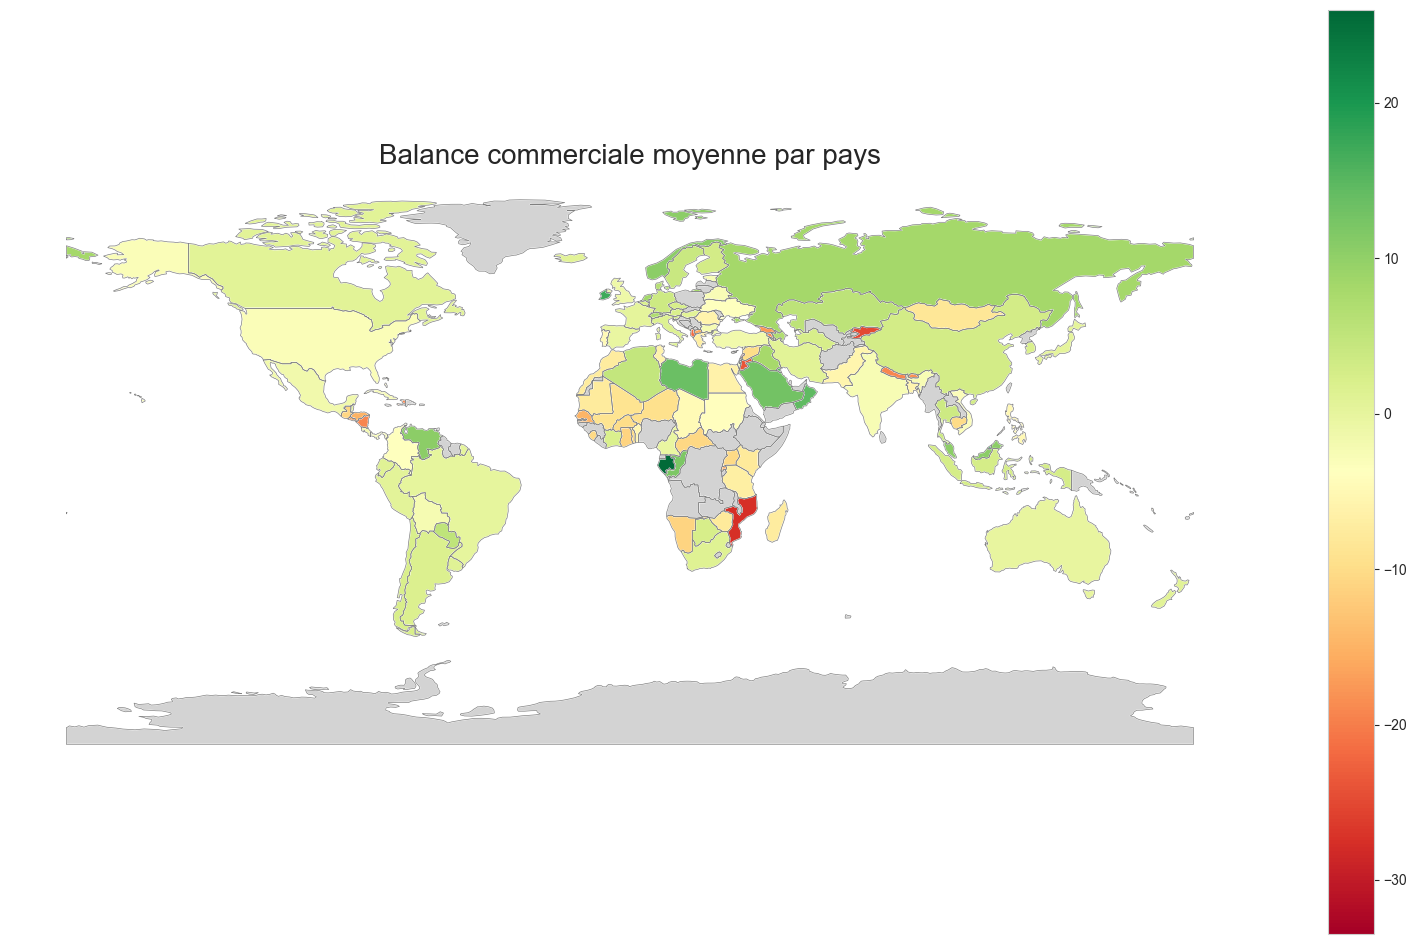

In [ ]:
world = gpd.read_file("ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp")
# Fusionner avec les codes ISO et le shapefile
avg_balance = trade_data.groupby('country')['commBalance'].mean().reset_index()
avg_balance = avg_balance.merge(codesISO_data[['ISO-3','Pays']], left_on='country', right_on='ISO-3', how='left')
world_map = world.merge(avg_balance, left_on='ADM0_A3', right_on='ISO-3', how='left')

# Tracer la carte
fig, ax = plt.subplots(1, 1, figsize=(20,12))
world.boundary.plot(ax=ax, linewidth=0.5, color='gray')
world_map.plot(
    column='commBalance',
    ax=ax,
    legend=True,
    cmap='RdYlGn',
    missing_kwds={"color": "lightgrey"},
)
ax.set_title("Balance commerciale moyenne par pays", fontsize=20)
ax.axis('off')
plt.show()

### Classification en pays exportateurs nets

In [ ]:
netExportators = trade_analyzer.classify_exporters(threshold=0)
netExportators

,country,netExportateur
0,ALB,0
1,ARG,1
2,ARM,0
3,AUS,0
4,AUT,1
...,...,...
126,VEN,1
127,VNM,0
128,VUT,0
129,ZAF,1


### Visualisation sur une carte

Nous représentons sur une carte la variable binaire identifiant les pays exportateurs nets. La carte met en évidence une forte concentration de ces pays dans les économies avancées et riches en ressources (Europe occidentale, pays du Golfe, certaines économies asiatiques), tandis que de nombreux pays d’Afrique et d’Amérique latine apparaissent majoritairement importateurs nets. Cette répartition confirme l’existence d’un clivage structurel dans le commerce international et suggère que le statut d’exportateur net est étroitement lié au niveau de développement économique et à la spécialisation productive.

In [ ]:
dv.visualize_trade_clusters(netExportators)

## 5. Analyse des pays enclavés

In [ ]:
try:
    landlocked_data = dc.get_rawlandlockedCountries(landlocked_url)
    landlocked_data = dcl.clean_landlockedData(landlocked_data)
except Exception as e:
    print(f"An error occurred while fetching or cleaning ISO codes data: {e}")
    landlocked_data = pd.read_csv("data/landlocked_data.csv")
    landlocked_data.drop(columns=['Unnamed: 0'], inplace=True)

landlocked_data

,country,Coastline
0,Canada,265523.0
1,Norway,53199.0
2,Indonesia,95181.0
3,Russia,110310.0
4,Philippines,33900.0
...,...,...
190,French Guiana,763.0
191,Guadeloupe,581.0
192,Martinique,369.0
193,Caribbean Netherlands,361.0


In [ ]:
landlocked_data["country"] = landlocked_data['country'].apply(lambda x: finalMatchingDictionnary[x] if x in finalMatchingDictionnary.keys() else x)
landlocked_data[landlocked_data['country'].str.len() > 3]

,country,Coastline
3,Russia,110310.0
16,Turkey,8140.0
19,Micronesia,1295.0
31,Bahamas,11238.0
32,Vietnam,11409.0
33,Somalia,3898.0
38,Venezuela,6762.0
43,French Polynesia,5830.0
44,North Korea,4009.0
47,Egypt,5898.0


En essayant d'assigner aux pays leurs codes ISO, on remarque que certains d'entre eux ne sont pas assignés. Il s'agit notamment de ceux dans la table ci-dessus. Pour palier à cela nous allons créer un dictionnaire et assigner manuellement les pays problématiques à leurs codes ISO.

In [ ]:
problematic_countriesMatching = {
    "Russia": "RUS",
    "Turkey": "TUR",
    "Micronesia": "FSM",
    "Bahamas": "BHS",
    "Vietnam": "VNM",
    "Somalia": "SOM",
    "Venezuela": "VEN",
    "French Polynesia": "PYF",
    "North Korea": "PRK",
    "Egypt": "EGY",
    "Iran": "IRN",
    "South Korea": "KOR",
    "New Caledonia": "NCL",
    "Yemen": "YEM",
    "Taiwan": "TWN",
    "Cape Verde": "CPV",
    "Hong Kong": "HKG",
    "Ivory Coast": "CIV",
    "Puerto Rico": "PRI",
    "São Tomé and Príncipe": "STP",
    "Syria": "SYR",
    "U.S. Virgin Islands": "VIR",
    "Congo, Republic of the": "COG",
    "Congo, Democratic Republic of the": "COD",
    "Brunei": "BRN",
    "Saint Lucia": "LCA",
    "Bermuda": "BMU",
    "Saint Vincent and the Grenadines": "VCT",
    "Gambia": "GMB",
    "Aruba": "ABW",
    "Macau": "MAC",
    "Czech Republic": "CZE",
    "Kyrgyzstan": "KGZ",
    "Laos": "LAO",
    "Slovakia": "SVK",
    "Swaziland": "SWZ",
    "French Guiana": "GUF",
    "Guadeloupe": "GLP",
    "Martinique": "MTQ",
    "Caribbean Netherlands": "BES",
    "Réunion": "REU",
    "Turkey": "TUR"
}

In [ ]:
landlocked_data["country"] = landlocked_data['country'].apply(lambda x: problematic_countriesMatching[x] if x in problematic_countriesMatching.keys() else x)
validLandlockedData = landlocked_data.copy()
validLandlockedData

,country,Coastline
0,CAN,265523.0
1,NOR,53199.0
2,IDN,95181.0
3,RUS,110310.0
4,PHL,33900.0
...,...,...
190,GUF,763.0
191,GLP,581.0
192,MTQ,369.0
193,BES,361.0


On va créer une colonne binaire pour indiquer si un pays est enclavé ou non.

In [ ]:
validLandlockedData['isLandlocked'] = (validLandlockedData['Coastline'] == 0).astype(int)
validLandlockedData.drop(columns=['Coastline'],inplace=True)
validLandlockedData

,country,isLandlocked
0,CAN,0
1,NOR,0
2,IDN,0
3,RUS,0
4,PHL,0
...,...,...
190,GUF,0
191,GLP,0
192,MTQ,0
193,BES,0


In [ ]:
dv.visualize_landlocked_countries(validLandlockedData)
plt.show()

## 6. Indice de Développement Humain (IDH)

Après avoir étudié la structure commerciale des pays à travers leurs importations et exportations, il est pertinent d’introduire une dimension plus structurelle du développement. Le commerce extérieur renseigne sur l’insertion internationale des économies, mais il ne suffit pas à capturer leur niveau de développement humain, qui conditionne fortement leur capacité à absorber et surmonter les chocs. C’est dans cette optique que l’on introduit l’Indice de Développement Humain (HDI), indicateur synthétique central pour compléter l’analyse.

Le jeu de données HDI importé contient les valeurs annuelles de l’Indice de Développement Humain pour l’ensemble des pays, ainsi qu’un agrégat mondial, sur la période 1990–2023. À l’origine, la base est relativement riche (10 colonnes), mais seule une partie de l’information est utile pour l’analyse : le pays, l’année et la valeur de l’HDI.

In [ ]:
HDI_data = pd.read_excel("data/hdi-data.xlsx")
HDI_data

,countryIsoCode,country,indexCode,index,dimension,indicatorCode,indicator,year,value,note
0,AFG,Afghanistan,HDI,Human Development Index,NaN,hdi,Human Development Index (value),1990,0.285,NaN
1,AFG,Afghanistan,HDI,Human Development Index,NaN,hdi,Human Development Index (value),1991,0.291,NaN
2,AFG,Afghanistan,HDI,Human Development Index,NaN,hdi,Human Development Index (value),1992,0.301,NaN
3,AFG,Afghanistan,HDI,Human Development Index,NaN,hdi,Human Development Index (value),1993,0.311,NaN
4,AFG,Afghanistan,HDI,Human Development Index,NaN,hdi,Human Development Index (value),1994,0.305,NaN
...,...,...,...,...,...,...,...,...,...,...
6309,ZZK.WORLD,World,HDI,Human Development Index,NaN,hdi,Human Development Index (value),2019,0.745,NaN
6310,ZZK.WORLD,World,HDI,Human Development Index,NaN,hdi,Human Development Index (value),2020,0.742,NaN
6311,ZZK.WORLD,World,HDI,Human Development Index,NaN,hdi,Human Development Index (value),2021,0.742,NaN
6312,ZZK.WORLD,World,HDI,Human Development Index,NaN,hdi,Human Development Index (value),2022,0.752,NaN


In [ ]:
print("Il y a", HDI_data["country"].nunique(), "pays uniques dans le dataset HDI avant nettoyage.")

Il y a 204 pays uniques dans le dataset HDI avant nettoyage.


La classe HDIDataAnalyzer permet de nettoyer et de restructurer ces données. Le traitement consiste essentiellement à :

-filtrer l’indicateur pertinent (HDI),

-harmoniser les identifiants pays (codes ISO),

-renommer les variables pour plus de clarté,

-éliminer les colonnes redondantes ou non exploitables.

On obtient ainsi une base finale épurée de 5 940 observations, avec une structure simple et cohérente : une observation par pays et par année, et une variable continue `HDI` comprise entre 0 et 1. Cette base est directement exploitable pour des analyses descriptives (comparaisons entre pays, dynamiques temporelles) et servira ensuite de fondement pour relier le niveau de développement humain aux autres dimensions étudiées dans le projet.

In [ ]:
hdiAnalyzer = da.HDIDataAnalyzer(HDI_data=HDI_data)
HDI_cleaned = hdiAnalyzer.clean_data()
HDI_cleaned

,country,date,HDI
0,AFG,1990,0.285
1,AFG,1991,0.291
2,AFG,1992,0.301
3,AFG,1993,0.311
4,AFG,1994,0.305
...,...,...,...
5935,ZWE,2019,0.584
5936,ZWE,2020,0.582
5937,ZWE,2021,0.581
5938,ZWE,2022,0.594


In [ ]:
HDI_cleaned["country"].nunique()
print("Il y a", HDI_cleaned["country"].nunique(), "pays uniques dans le dataset HDI après nettoyage.")

Il y a 193 pays uniques dans le dataset HDI après nettoyage.


On vérifie qu'on n'a bel et bien pas de valeurs manquantes.

In [ ]:
da.check_missing_values(HDI_cleaned,"HDI")

Le dataframe contient des données temporelles relatives à 193 pays de 1990 à 2023.
Il y a 0 valeurs manquantes sur un total de 5940 dans la base de données.
Soit un ratio de 0.00% de valeurs manquantes dans la base de données.



Le dataset contient 193 pays distincts après nettoyage.
En moyenne, chaque pays dispose d’environ 31 années de données HDI.
La médiane est de 34 années, ce qui correspond quasiment à la période complète 1990–2023.

In [ ]:
HDI_cleaned.groupby("country")["date"].count().describe()

count    193.000000
mean      30.777202
std        5.936039
min        2.000000
25%       29.000000
50%       34.000000
75%       34.000000
max       34.000000
Name: date, dtype: float64

Nous agrégeons ensuite l’Indice de Développement Humain au niveau des pays en calculant, pour chacun d’eux, une valeur moyenne d’HDI sur l’ensemble de la période observée.
L’objectif est de disposer d’un indicateur synthétique et comparable du niveau moyen de développement humain, indépendamment des fluctuations annuelles.

En analysant l’indice de développement humain moyen par pays sur la période étudiée, on observe une nette hiérarchisation. Le top 10 regroupe des pays majoritairement européens et nord-américains, avec des HDI moyens supérieurs à 0,90, reflétant un niveau de vie élevé, une espérance de vie longue et un accès important à l’éducation. À l’inverse, le flop 10 inclut principalement des pays d’Afrique subsaharienne, avec des HDI moyens inférieurs à 0,42, témoignant de défis persistants en matière de santé, d’éducation et de conditions économiques.

In [ ]:
aggregated_HDI = hdiAnalyzer.aggregated_HDI()
# Tri par HDI moyen
HDI_avg = aggregated_HDI.sort_values(by="HDI_mean", ascending=False)

# Top 10 pays par HDI
top10_HDI = HDI_avg.head(10).reset_index(drop=True)
top10_HDI.index = range(1, len(top10_HDI)+1)
print("Top 10 pays par HDI :")
display(top10_HDI)

# Flop 10 pays par HDI
flop10_HDI = HDI_avg.tail(10).reset_index(drop=True)
flop10_HDI.index = range(1, len(flop10_HDI)+1)
print("\nFlop 10 pays par HDI :")
display(flop10_HDI)

Top 10 pays par HDI :


,country,HDI_mean
1,NOR,0.930912
2,ISL,0.922324
3,CHE,0.919324
4,DEU,0.916088
5,LIE,0.915958
6,AUS,0.914588
7,NLD,0.913706
8,DNK,0.911765
9,SWE,0.911147
10,USA,0.909147



Flop 10 pays par HDI :


,country,HDI_mean
1,GIN,0.401529
2,SOM,0.394500
3,SLE,0.379853
4,MOZ,0.374000
5,TCD,0.372292
6,SSD,0.372286
7,BDI,0.368294
8,MLI,0.357912
9,CAF,0.346625
10,NER,0.314412


**Cartographie**

Nous proposons une représentation plus visuelle à l'aide d'une carte dynamique. Un slider permet de sélectionner manuellement l'année souhaitée. Il est aussi possible de faire défiler automatiquement le temps de deux manières : lentement, avec le bouton ▶, et rapidement, avec le bouton « Quick ».

In [ ]:
dv.plot_world_map(HDI_cleaned, y_col='HDI', data_name='HDI', width=1000, height=600)

# Fusion des bases

Nous fusionnons à présent dans une seule base de données les différentes variables étudiées jusqu'ici.

In [ ]:
rawMerged_data = (
    aggregated_HDI
    .merge(responseTime_data, on=["country"], how="outer")
    .merge(validLandlockedData, on=["country"], how="outer")
    .merge(netExportators, on=["country"], how="outer")
    .merge(weightCountry, on=["country"], how="outer")
)

rawMerged_data.sort_values(by="country",ascending=True)

,country,HDI_mean,avgResponseTime,isLandlocked,netExportateur,avgWeightCountry
0,ABW,NaN,NaN,0.0,NaN,NaN
1,AFG,0.415853,NaN,1.0,NaN,NaN
2,AGO,0.527600,7.000000,0.0,NaN,0.102789
3,ALB,0.727824,2.500000,0.0,0.0,0.014390
4,AND,0.862833,7.333333,NaN,NaN,0.004423
...,...,...,...,...,...,...
206,WSM,0.694655,2.800000,0.0,NaN,0.001153
207,YEM,0.450853,NaN,0.0,NaN,NaN
208,ZAF,0.667618,2.500000,0.0,1.0,0.467089
209,ZMB,0.495559,2.666667,1.0,NaN,0.022936


On trouve des lignes où il y a certaines valeurs manquantes. Elles correspondent à des pays qui n'ont pas assez d'informations nécessaires pour notre analyse. Nous décidons donc de les enlever.

In [ ]:
merged_data = rawMerged_data.dropna().reset_index(drop=True).copy()
merged_data

,country,HDI_mean,avgResponseTime,isLandlocked,netExportateur,avgWeightCountry
0,ALB,0.727824,2.500000,0.0,0.0,0.014390
1,ARG,0.813059,3.142857,0.0,1.0,0.794444
2,ARM,0.716588,4.000000,1.0,0.0,0.012410
3,AUS,0.914588,2.000000,0.0,0.0,1.813210
4,AUT,0.893706,2.666667,1.0,1.0,0.583008
...,...,...,...,...,...,...
113,USA,0.909147,2.000000,0.0,0.0,26.231174
114,VEN,0.721382,3.000000,0.0,1.0,0.167162
115,VUT,0.595632,4.500000,0.0,0.0,0.001050
116,ZAF,0.667618,2.500000,0.0,1.0,0.467089


# Standardisation des variables

Avant de réaliser la régression, il est essentiel de préparer les variables explicatives afin que le modèle soit fiable et facilement interprétable. Dans notre dataset, certaines variables présentent des échelles très différentes ou des distributions asymétriques, ce qui peut biaiser les coefficients estimés et compliquer la convergence du modèle.

Nous avons choisi de standardiser certaines variables quantitatives, à savoir `HDI_mean` et `avgWeightCountry`. La standardisation consiste à centrer les valeurs autour de zéro et à les réduire pour que l’écart-type soit égal à un. Cela permet au modèle de traiter toutes les variables sur une même échelle, ce qui facilite l’interprétation des coefficients. Concrètement, un coefficient standardisé représente l’effet d’un écart-type de variation de la variable sur la variable expliquée (avgResponseTime), ce qui rend plus intuitif la comparaison de l’impact relatif des différentes variables.

La variable `avgWeightCountry` présentait par ailleurs une distribution très asymétrique, avec beaucoup de pays de petit poids et quelques pays très lourds économiquement. Pour limiter l’influence de ces valeurs extrêmes, nous avons appliqué une transformation logarithmique (log1p). Cette transformation réduit l’asymétrie de la distribution, stabilise la variance et améliore la fiabilité des coefficients estimés par la régression.

Enfin, les variables `isLandlocked` ou `netExportateur`, codées en binaire, n’ont pas été standardisées. Ces variables représentent déjà des indicateurs simples 0/1, et leur interprétation dans la régression reste directe sans transformation.

In [ ]:
# Transformation log pour avgWeightCountry
merged_data['avgWeightCountry_log'] = np.log1p(merged_data['avgWeightCountry'])

# Standardisation de HDI_mean et avgWeightCountry_log
scaler = StandardScaler()
merged_data[['HDI_mean_std', 'avgWeightCountry_std']] = scaler.fit_transform(
    merged_data[['HDI_mean', 'avgWeightCountry_log']]
)

# Vérification des résultats
merged_data[['HDI_mean', 'HDI_mean_std', 'avgWeightCountry', 'avgWeightCountry_log', 'avgWeightCountry_std']].head()
merged_data[['HDI_mean_std', 'avgWeightCountry_std']].describe()

,HDI_mean_std,avgWeightCountry_std
count,1.180000e+02,1.180000e+02
mean,9.446304e-16,-3.951641e-17
std,1.004264e+00,1.004264e+00
min,-2.552445e+00,-5.941761e-01
25%,-6.719764e-01,-5.595898e-01
50%,1.057664e-01,-4.615719e-01
75%,7.846490e-01,2.920785e-02
max,1.453362e+00,5.851384e+00


# Etude des corrélations 

Avant de nous attaquer à la régression, il est important de réaliser une étude des corrélations afin de comprendre les relations existantes entre la variable expliquée et les variables explicatives, mais aussi entre les variables explicatives elles-mêmes. Cette étape permet d’identifier les variables qui pourraient avoir un effet significatif sur la variable cible, d’anticiper les problèmes de multicolinéarité, et d’orienter le choix des variables à inclure dans le modèle

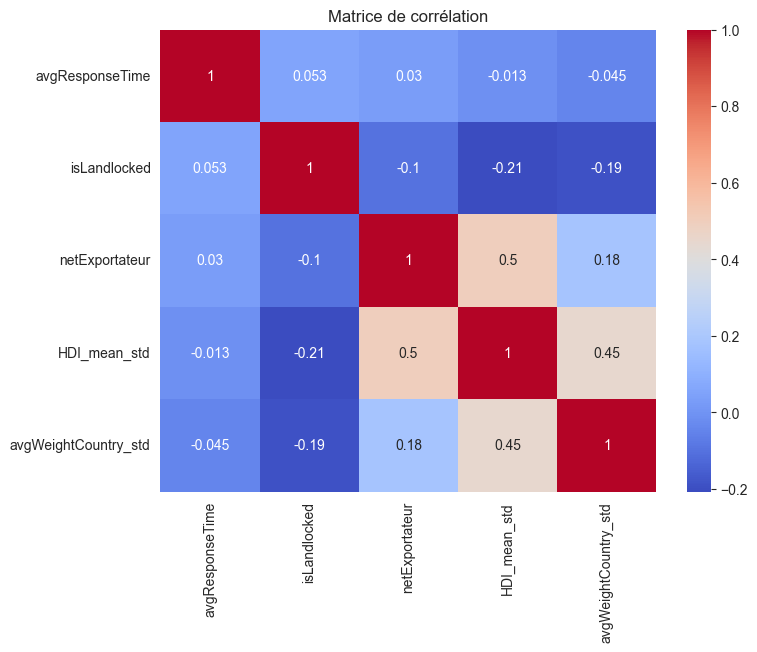

In [ ]:
regression_data = merged_data[['avgResponseTime', 'isLandlocked', 'netExportateur', 'HDI_mean_std', 'avgWeightCountry_std']].copy()
numeric_cols = regression_data.select_dtypes(include=['float64', 'int64'])
corr_matrix = numeric_cols.corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Matrice de corrélation")
plt.show()

L’analyse des corrélations montre que la variable expliquée, `avgResponseTime`, présente toujours très peu de lien avec les variables explicatives du jeu de données. En effet, la corrélation avec le HDI moyen standardisé (`HDI_mean_std`) est modérément négative sinon même quasi-nulle. Cela suggère qu'un niveau de développement humain élevé d’un pays traduit un temps moyen de réponse plus court mais dans des proportions très infimes. De même, le fait d’être un pays enclavé (`isLandlocked`) ou un pays exportateur net (`netExportateur`) n’affecte presque pas avgResponseTime, avec des corrélations respectives de 0,067 et -0,0021. Le poids économique relatif standardisé d’un pays (`avgWeightCountry_std`) montre une corrélation négative (-0,12), indiquant que les pays économiquement plus “lourds” tendent à avoir des temps de réponse un peu plus courts, mais l’effet reste très faible.

Concernant les variables explicatives elles-mêmes, quelques tendances apparaissent. Le HDI moyen standardisé (`HDI_mean_std`) est faiblement négativement corrélé avec le fait d’être enclavé (`isLandlocked`, -0,21), ce qui signifie que les pays sans accès à la mer ont en moyenne un développement humain légèrement inférieur. Il existe également une corrélation modérée positive entre HDI_mean_std et le statut de pays exportateur net (`netExportateur`, 0,51), ce qui indique que les pays exportateurs nets tendent à avoir un niveau de développement plus élevé. Les autres corrélations entre variables explicatives sont faibles ou quasi nulles, comme entre `netExportateur` et `avgWeightCountry_std` (0,24), ce qui indique que ces variables mesurent des dimensions différentes et qu’il n’y a pas de problème de multicolinéarité majeur.

En synthèse, les facteurs géographiques et économiques présents dans le jeu de données semblent avoir un impact très limité sur le temps moyen de réponse. Si l’on souhaite modéliser avgResponseTime par régression multiple, il est probable que la proportion de variance expliquée par le modèle soit faible, mais le modèle pourra néanmoins donner des indications sur la direction et l’importance relative de chaque variable explicative.

In [ ]:
corr_list = []
for i in range(len(corr_matrix.columns)):
    for j in range(i, len(corr_matrix.columns)):
        corr_list.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

# Affichage
for item in corr_list:
    print(f"{item[0]} - {item[1]}: {item[2]:.3f}")

avgResponseTime - avgResponseTime: 1.000
avgResponseTime - isLandlocked: 0.053
avgResponseTime - netExportateur: 0.030
avgResponseTime - HDI_mean_std: -0.013
avgResponseTime - avgWeightCountry_std: -0.045
isLandlocked - isLandlocked: 1.000
isLandlocked - netExportateur: -0.101
isLandlocked - HDI_mean_std: -0.207
isLandlocked - avgWeightCountry_std: -0.190
netExportateur - netExportateur: 1.000
netExportateur - HDI_mean_std: 0.500
netExportateur - avgWeightCountry_std: 0.182
HDI_mean_std - HDI_mean_std: 1.000
HDI_mean_std - avgWeightCountry_std: 0.446
avgWeightCountry_std - avgWeightCountry_std: 1.000


Pour compléter l’étude des corrélations entre variables, il est utile de calculer le facteur d’inflation de la variance, ou **VIF (Variance Inflation Factor)**. Le VIF mesure dans quelle mesure la variance estimée d’un coefficient de régression est amplifiée par la présence de corrélations entre les variables explicatives. En d’autres termes, il permet de détecter la multicolinéarité : plus le VIF est élevé, plus une variable est redondante avec les autres, ce qui peut rendre les coefficients instables et difficiles à interpréter.

In [ ]:
# Sélection des variables explicatives
X = regression_data[['isLandlocked', 'netExportateur', 'HDI_mean_std', 'avgWeightCountry_std']]

# Calcul du VIF pour chaque variable
vif_data = pd.DataFrame()
vif_data['Variable'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

               Variable       VIF
0          isLandlocked  1.156496
1        netExportateur  1.285309
2          HDI_mean_std  1.507321
3  avgWeightCountry_std  1.261629


L’analyse des facteurs d’inflation de la variance (VIF) pour les variables explicatives montre que toutes les valeurs sont très faibles, comprises entre **1,16 et 1,52**. Cela indique que les variables présentent très peu de corrélation linéaire entre elles. En pratique, un **VIF inférieur à 5** est considéré comme acceptable, et ici toutes les valeurs sont largement en dessous de ce seuil, ce qui suggère qu’il n’existe pas de problème notable de multicolinéarité.

Autrement dit, chacune de ces variables apporte une information relativement indépendante pour expliquer la variable avgResponseTime. Cela permet de procéder à une régression multiple en toute confiance, car les coefficients estimés ne seront pas faussés par des corrélations excessives entre les variables explicatives. Le modèle pourra ainsi évaluer de manière fiable l’effet relatif de chaque variable sur le temps moyen de réponse.

# Implémentation de la régression

Après cette étape préliminaire d'étude des différentes variables utilisées, il est temps à présent d'identifier si ces variables explicatives ont bel et bien un pouvoir explicatif sur le temps de réponse moyens des pays après une crise. Pour ce faire, l'estimation est réalisée par moindres carrés ordinaires avec des erreurs robustes à l'hétéroscédasticité. 

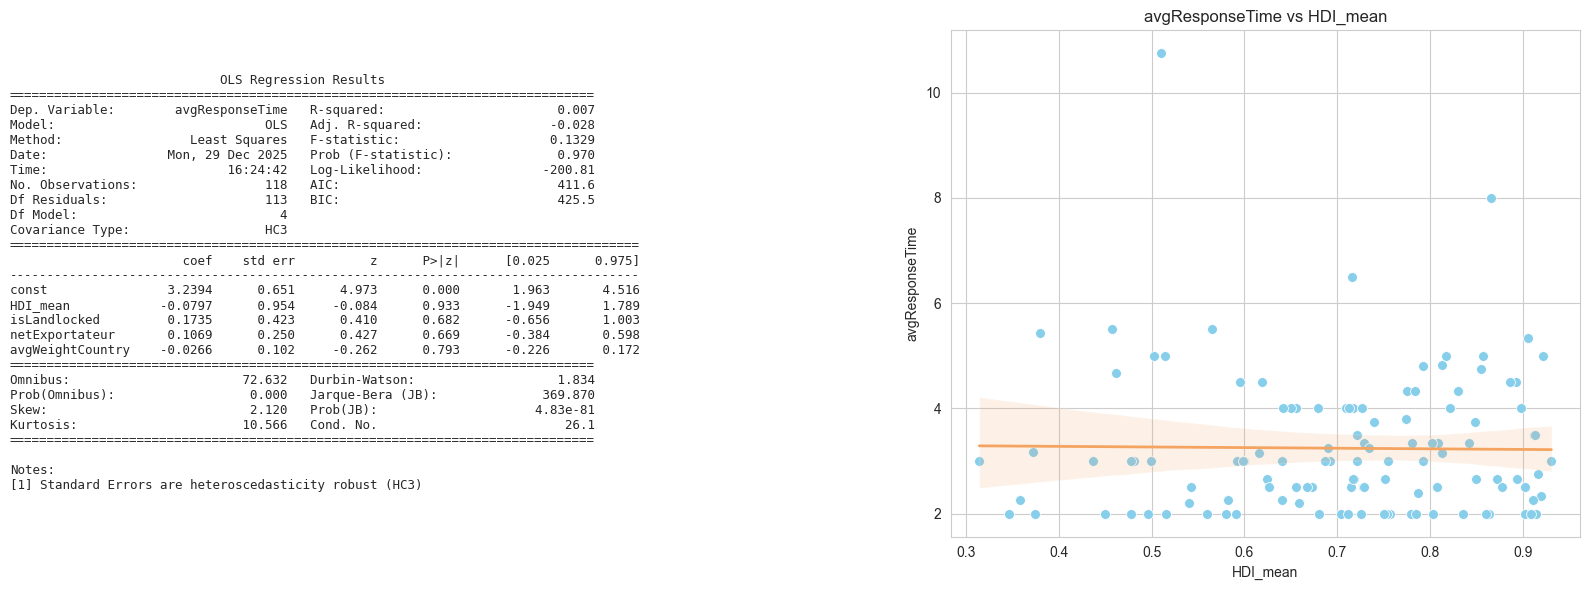


Coefficients standardisés :
           Variable  Coeff_std
0             const   3.241788
1          HDI_mean  -0.012325
2      isLandlocked   0.066640
3    netExportateur   0.053314
4  avgWeightCountry  -0.069460


In [ ]:
rg.perform_regression(merged_data, ['HDI_mean', 'isLandlocked', 'netExportateur', 'avgWeightCountry'],'avgResponseTime', method='HC3')

# Résultats principaux 

Les résultats de la régression indiquent une capacité explicative très faible du modèle avec un coefficient de détermination de **1.5%**, ce qui signifie que les variables retenues expliquent une part négligeable de la variance de `avgResponseTime`. De plus, aucun coefficient associé aux variables explicatives n’est statistiquement significatif aux seuils usuels à part celui associé à `avgWeightCountry` qui est significatif au seuil de **10%** dû à une p-valeur de **8.8%**. Les signes des coefficients sont globalement faibles et instables, ce qui est cohérent avec l’analyse préalable des corrélations, qui montrait déjà l’absence de relation linéaire forte entre la variable expliquée et les variables explicatives. Enfin, le test global du modèle (F-statistic) confirme que l’ensemble des variables n’apporte pas d’information significative pour expliquer le temps moyen de reprise.

# Interprétation économique

Ces résultats suggèrent que le temps moyen de réponse après une crise ne dépend pas directement du niveau moyen de développement humain, du poids économique global, du statut géographique d’un pays ou de sa position commerciale nette. Autrement dit, des pays plus développés ou économiquement plus importants ne se remettent pas nécessairement plus vite des crises que d’autres. Cela peut s’expliquer par le fait que la dynamique de sortie de crise est fortement conditionnée par des facteurs spécifiques aux crises elles-mêmes (nature du choc, politiques publiques mises en œuvre, institutions, contexte politique ou sanitaire) qui ne sont pas capturés par les variables structurelles utilisées ici.

Cependant, après avoir constaté cette faiblesse du pouvoir méthodologique observé dans cette régression linéaire multiple "classique", la logique méthodologique consiste à se demander si cette faiblesse ne provient pas plutôt d’une mauvaise spécification du modèle, plutôt que de l’inexistence de relations économiques. En effet, la régression linéaire suppose implicitement des relations linéaires, additives et homogènes entre la variable expliquée (`avgResponseTime`) et les variables explicatives. Or, dans un contexte macro-économique et institutionnel, il est raisonnable de penser que ces relations puissent être non linéaires (effets de seuil, rendements décroissants) ou dépendre de combinaisons de variables (interactions). Tester ces hypothèses constitue donc une étape naturelle après une première estimation peu convaincante.

# Régression non linéaires 

La première extension consiste à introduire des relations non linéaires (par exemple des termes quadratiques). L’idée est que l’effet marginal d’une variable comme le niveau de développement `HDI_mean` ou le poids économique `avgWeightCountry` sur le temps de reprise puisse varier selon son niveau. Par exemple, une amélioration du HDI peut accélérer fortement la reprise pour des pays peu développés, mais produire des gains beaucoup plus faibles une fois un certain seuil atteint.

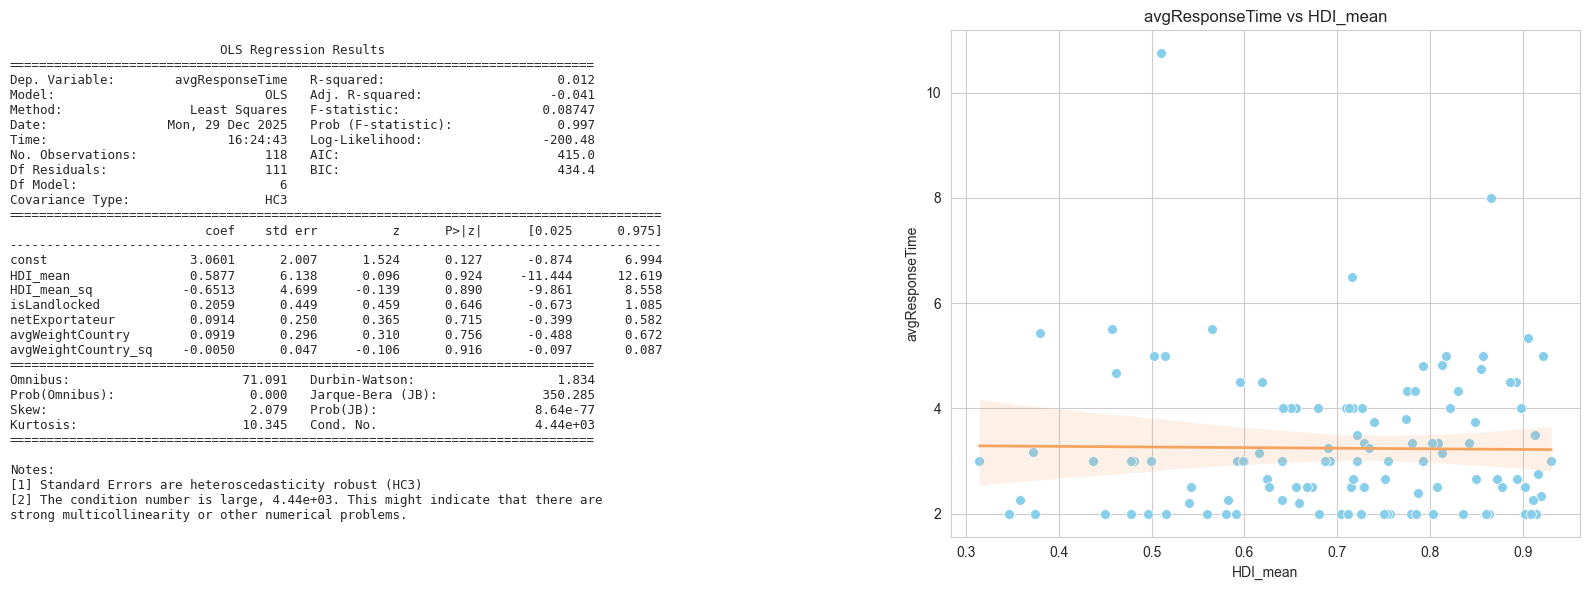


Coefficients standardisés :
              Variable  Coeff_std
0                const   3.241788
1             HDI_mean   0.090827
2          HDI_mean_sq  -0.134770
3         isLandlocked   0.079094
4       netExportateur   0.045565
5     avgWeightCountry   0.239753
6  avgWeightCountry_sq  -0.314848


In [ ]:
merged_data_nl = merged_data.copy()

merged_data_nl['HDI_mean_sq'] = merged_data_nl['HDI_mean'] ** 2
merged_data_nl['avgWeightCountry_sq'] = merged_data_nl['avgWeightCountry'] ** 2

rg.perform_regression(merged_data_nl, ['HDI_mean', 'HDI_mean_sq', 'isLandlocked', 'netExportateur', 'avgWeightCountry', 'avgWeightCountry_sq'],'avgResponseTime', method='HC3')

Empiriquement, cette approche améliore légèrement le R² (de **1.5%** à **1,6%**), ce qui indique que le modèle capte un peu plus de variance. Cependant, la baisse du R²-ajusté (de **-0.020** à **-0.038**)  montre que ce gain est essentiellement mécanique : l’ajout de paramètres supplémentaires n’améliore pas réellement la qualité explicative une fois la pénalisation pour complexité prise en compte. L’absence persistante de coefficients significatifs confirme que la non-linéarité, bien que plausible théoriquement, n’est pas suffisante là aussi pour structurer fortement la relation dans les données disponibles.

# Régressions avec interactions entre les variables explicatives 

La seconde extension introduit des termes d’interaction, afin de tester si l’effet d’une variable dépend du contexte fourni par une autre (par exemple, l’effet du HDI selon que le pays est enclavé ou non, ou selon sa position commerciale). Les interactions choisies sont fondées sur des hypothèses économiques plausibles : 

- `HDI_mean × isLandlocked` : Cette interaction repose sur l’idée que le niveau de développement humain n’est pas également mobilisable selon la géographie du pays. Un HDI élevé reflète un bon capital humain, des institutions relativement solides et des infrastructures sociales développées. Cependant, pour un pays enclavé, ces atouts peuvent être partiellement contraints par des coûts de transport plus élevés, une dépendance vis-à-vis des pays voisins et un accès plus limité aux marchés internationaux. Ainsi, même à HDI comparable, un pays enclavé peut rencontrer davantage de difficultés à réallouer rapidement ses ressources après une crise. L’interaction permet donc de tester si l’effet du développement humain sur la vitesse de reprise est conditionné par l’accès géographique aux échanges internationaux, plutôt que d’être uniforme pour tous les pays.

- `HDI_mean × netExportateur` : Cette interaction s’inscrit dans une logique de complémentarité entre développement et insertion commerciale. Un pays à haut HDI dispose en principe d’une main-d’œuvre plus qualifiée, de meilleures capacités productives et d’institutions plus efficaces, ce qui peut lui permettre de tirer davantage parti d’une position d’exportateur net lors de la reprise post-crise. À l’inverse, dans un pays à faible HDI, une spécialisation exportatrice peut être plus risquée, car elle repose souvent sur des secteurs peu diversifiés ou à faible valeur ajoutée, rendant l’économie plus vulnérable aux chocs externes. L’interaction teste donc si le statut d’exportateur net est réellement un facteur de résilience, ou s’il ne le devient qu’à partir d’un certain niveau de développement.

- `avgWeightCountry × netExportateur` : L'idée est de capturer un effet de taille économique dans la relation entre commerce extérieur et reprise. Les pays ayant un poids économique élevé disposent généralement de marchés intérieurs plus vastes, de marges budgétaires plus importantes et d’une plus grande capacité à soutenir leurs entreprises en période de crise. Dans ce contexte, être exportateur net peut renforcer la reprise sans exposer excessivement l’économie aux fluctuations externes. À l’inverse, pour les petites économies, une forte dépendance aux exportations peut accroître la vulnérabilité face à une contraction de la demande mondiale. L’interaction permet ainsi d’évaluer si l’effet du commerce extérieur sur le temps de reprise est amorti ou amplifié par la taille économique du pays.

- `HDI_mean × avgWeightCountry` : Cette interaction repose sur l’idée que le rendement du développement humain peut dépendre de l’échelle économique. Dans une grande économie, un niveau élevé de HDI peut être plus efficacement transformé en capacité de résilience : diversification sectorielle, politiques publiques plus larges, systèmes financiers plus profonds. À l’inverse, dans une petite économie, même avec un bon niveau de développement humain, les marges d’action restent limitées par la taille du marché, la dépendance extérieure ou la spécialisation productive. Tester cette interaction revient donc à examiner si le développement humain est plus “productif” en termes de reprise lorsqu’il s’appuie sur une base économique large.

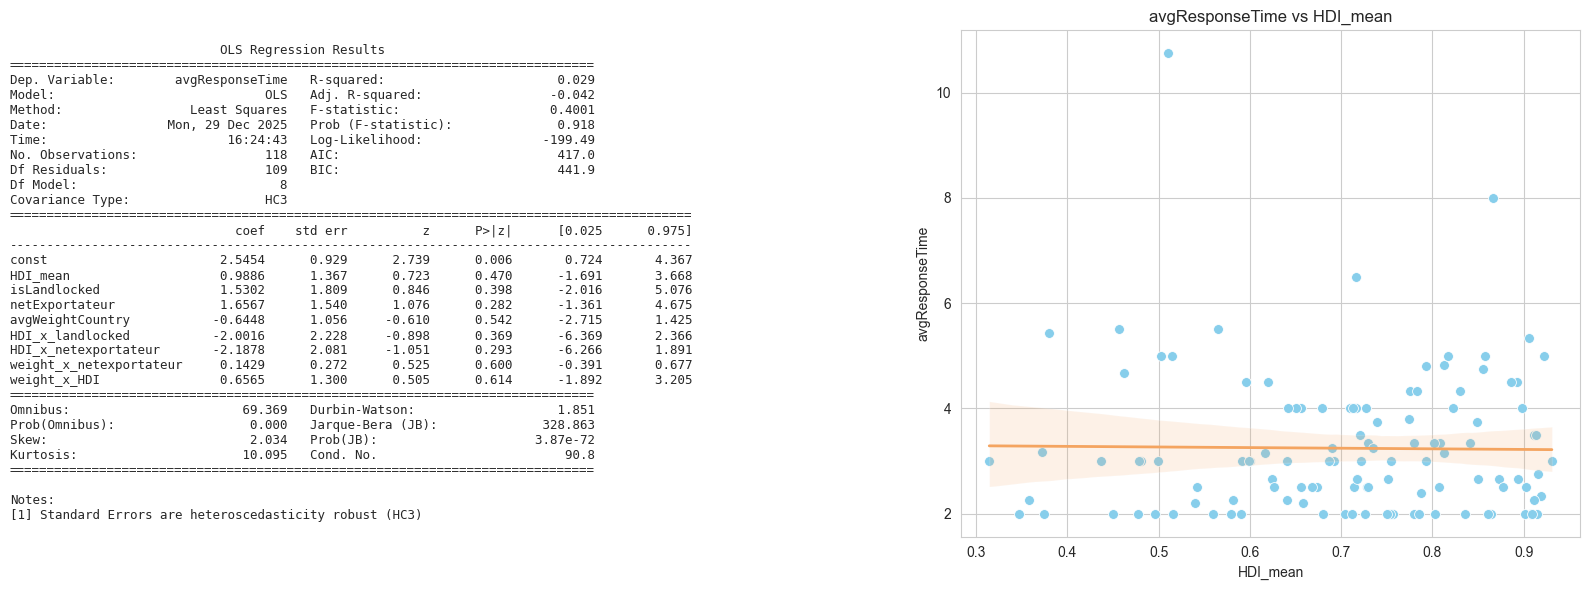


Coefficients standardisés :
                  Variable  Coeff_std
0                    const   3.241788
1                 HDI_mean   0.152800
2             isLandlocked   0.587790
3           netExportateur   0.826019
4         avgWeightCountry  -1.682580
5         HDI_x_landlocked  -0.515546
6     HDI_x_netexportateur  -0.879308
7  weight_x_netexportateur   0.141572
8             weight_x_HDI   1.551003


In [ ]:
merged_data_int = merged_data.copy()

merged_data_int['HDI_x_landlocked'] = (
    merged_data_int['HDI_mean'] * merged_data_int['isLandlocked']
)

merged_data_int['HDI_x_netexportateur'] = (
    merged_data_int['HDI_mean'] * merged_data_int['netExportateur']
)

merged_data_int['weight_x_netexportateur'] = (
    merged_data_int['avgWeightCountry'] * merged_data_int['netExportateur']
)

merged_data_int['weight_x_HDI'] = (
    merged_data_int['avgWeightCountry'] * merged_data_int['HDI_mean']
)

rg.perform_regression(merged_data_int, ['HDI_mean', 'isLandlocked', 'netExportateur', 'avgWeightCountry', 'HDI_x_landlocked', 'HDI_x_netexportateur', 'weight_x_netexportateur', 'weight_x_HDI'],'avgResponseTime', method='HC3')

Ici encore, l’introduction des interactions conduit à une augmentation du R², qui atteint ici environ **3%**. Cela signifie que, mécaniquement, le modèle parvient à expliquer une part légèrement plus importante de la variance de `avgResponseTime` que la régression linéaire initiale. Cette hausse est attendue : en ajoutant des variables, on offre davantage de flexibilité au modèle, ce qui améliore presque toujours l’ajustement brut aux données.

Cependant, cette amélioration apparente est une nouvelle fois contredite par la baisse du R² ajusté. Le R² ajusté pénalise explicitement l’ajout de variables lorsque celles-ci n’apportent pas un gain explicatif suffisant par rapport à leur coût en degrés de liberté. Autrement dit, l’augmentation du R² est essentiellement due à une complexification du modèle, et non à une réelle capacité accrue à expliquer le phénomène étudié.

Le fait que les coefficients restent non significatifs au seuil de 5 % renforce cette interprétation. Cela suggère que ni les variables de base, ni leurs interactions, n’exercent d’effet statistiquement identifiable sur le temps moyen de reprise, compte tenu de la taille de l’échantillon et de la variabilité des données. Les relations postulées sont économiquement plausibles, mais empiriquement faibles ou très bruitées dans ce jeu de données.

# Régressions séparées

Après avoir constaté que la régression globale sur l’ensemble des pays expliquait très peu la variabilité de `avgResponseTime`, l’idée ici est d’introduire une hétérogénéité structurelle entre pays. L’hypothèse sous-jacente est que les mécanismes de reprise après crise ne sont pas nécessairement les mêmes pour les grandes économies que pour les petites.

Le code s’appuie sur une classification préalable (`clusters_EconomicPower`) faite plus haut qui regroupe les pays selon leur puissance économique.

Les pays avec Power = 1, 2 ou 3 sont considérés comme des pays à puissance économique moyenne ou élevée.
Les pays avec Power = 0 correspondent aux économies les plus faibles.

`dataHighPower` regroupe un sous-ensemble de pays économiquement plus puissants, complété par une partie des pays faibles, afin d’obtenir un échantillon réduit mais relativement homogène.

`dataLowPower` regroupe le reste des pays à faible puissance économique.

L’objectif ici est de tester si les déterminants du temps de reprise diffèrent selon le niveau de puissance économique.

In [ ]:
highPowerCountries = clusters_EconomicPower[(clusters_EconomicPower["Power"] == 2) | (clusters_EconomicPower["Power"] == 3) | (clusters_EconomicPower["Power"] == 1)]["country"].tolist()
lowPowerCountries = clusters_EconomicPower[(clusters_EconomicPower["Power"] == 0)].sort_values(by="avgWeightCountry",ascending=False)["country"].tolist()

dataHighPower = merged_data[merged_data["country"].isin(highPowerCountries[:-1]+lowPowerCountries[:11])]
dataLowPower = merged_data[merged_data["country"].isin(lowPowerCountries[11:])]

La régression réalisée sur le groupe des pays économiquement plus puissants conduit à un R² de **11,6 %**, ce qui représente une amélioration sensible par rapport aux régressions précédentes. Cela suggère qu’au sein de ce sous-groupe, les variables explicatives parviennent à capter une part plus importante de la variabilité du temps de reprise. Toutefois, cette amélioration doit être interprétée avec prudence. Le R² ajusté indique que le gain de R² ne compense pas la pénalisation liée au nombre de variables explicatives et à la très faible taille de l’échantillon. 

Du point de vue des coefficients individuels, toutes les variables demeurent non significatives aux seuils usuels de 1%, 5% et 10%, ce qui limite la portée interprétative du modèle et souligne la fragilité des résultats obtenus sur ce sous-échantillon restreint.

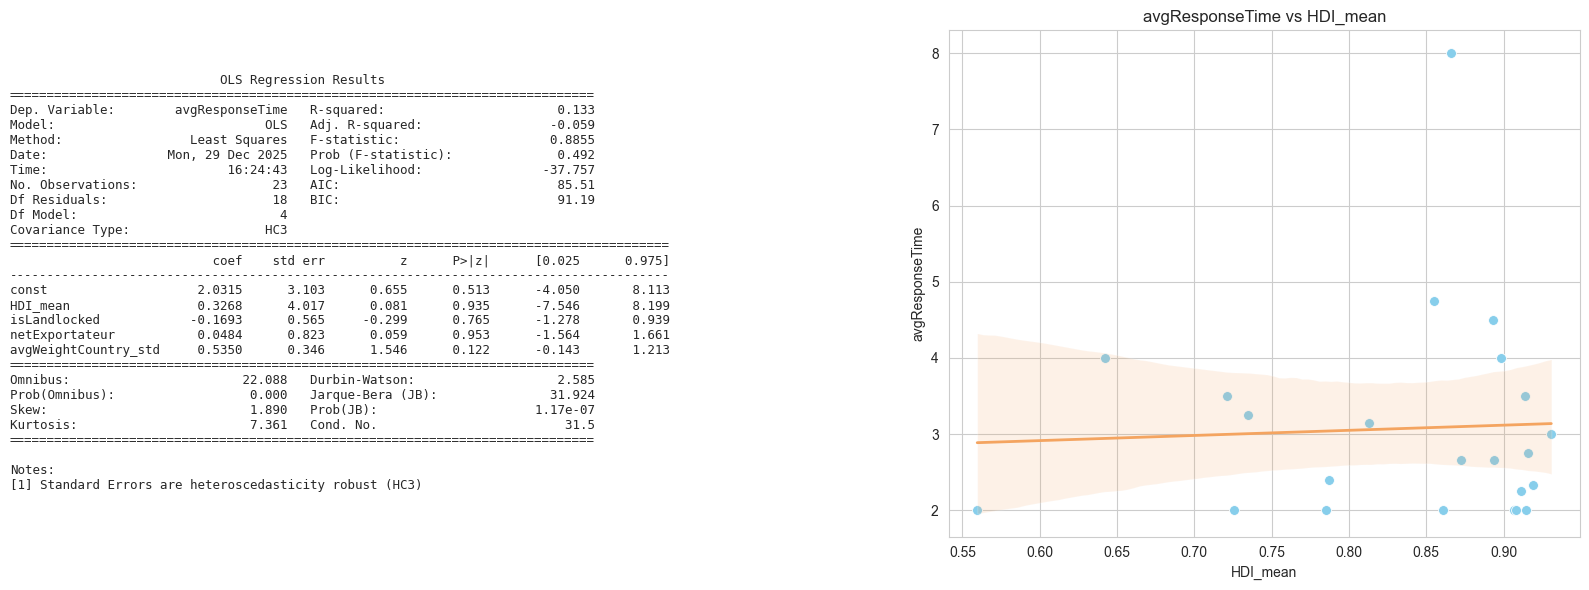


Coefficients standardisés :
               Variable  Coeff_std
0                 const   3.074327
1              HDI_mean   0.032627
2          isLandlocked  -0.048779
3        netExportateur   0.022755
4  avgWeightCountry_std   0.483943


In [ ]:
rg.perform_regression(dataHighPower, ['HDI_mean', 'isLandlocked', 'netExportateur', 'avgWeightCountry_std'],'avgResponseTime', method='HC3')

La régression menée sur le groupe des pays à faible puissance économique conduit à des résultats beaucoup plus proches de ceux observés dans l’analyse globale. Le R² est très faible (1,9 %) et le R² ajusté est également négatif (-0,026), indiquant que le modèle n’explique pratiquement pas la variabilité du temps de reprise. La statistique de Fisher n’est pas significative et aucun coefficient n’apparaît statistiquement différent de zéro. Cela suggère que, pour ces pays, les caractéristiques structurelles retenues ne suffisent pas à expliquer les différences observées en matière de reprise après crise.

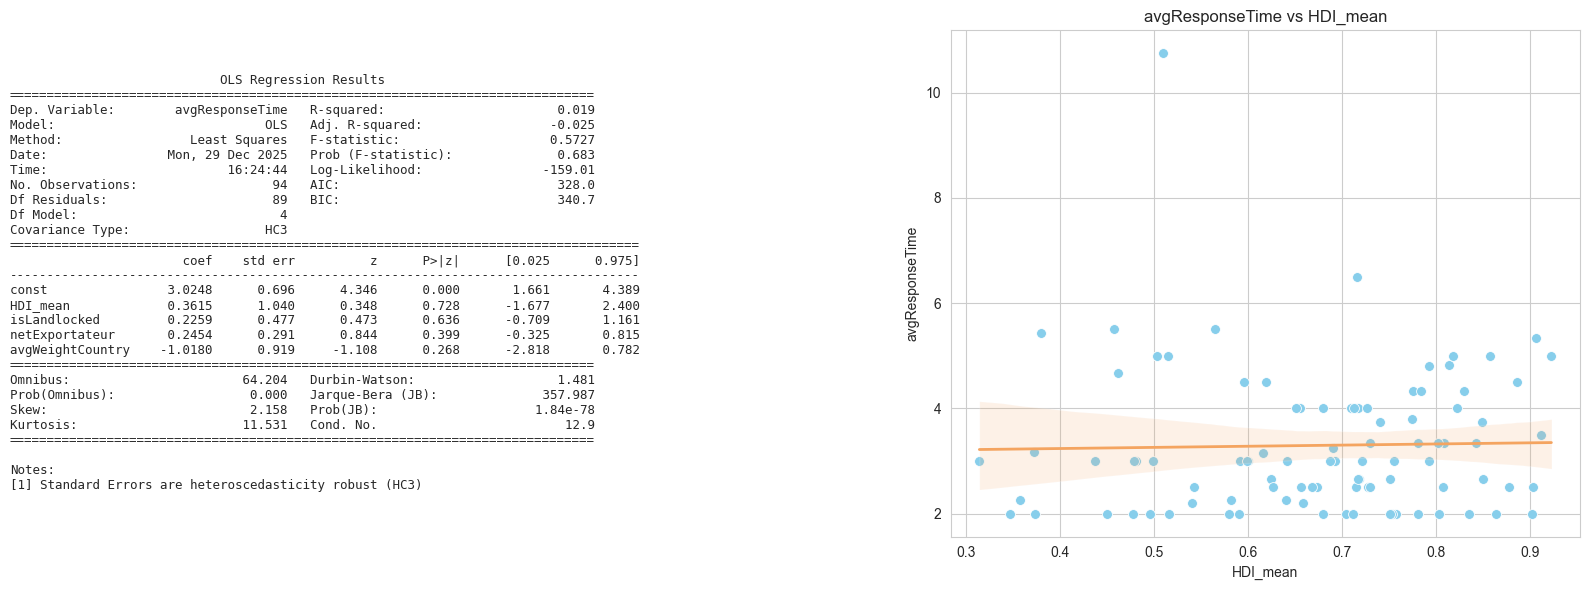


Coefficients standardisés :
           Variable  Coeff_std
0             const   3.295973
1          HDI_mean   0.053624
2      isLandlocked   0.091187
3    netExportateur   0.119915
4  avgWeightCountry  -0.145270


In [ ]:
rg.perform_regression(dataLowPower, ['HDI_mean', 'isLandlocked', 'netExportateur', 'avgWeightCountry'],'avgResponseTime', method='HC3')

# Conclusion et perspectives

Au terme de ce projet, l’objectif n’était pas tant de produire un modèle prédictif performant que de comprendre dans quelle mesure des caractéristiques structurelles des pays peuvent expliquer leur capacité moyenne à se relever d’une crise. En ce sens, l’ensemble des analyses menées converge vers un constat central : le temps de reprise économique après une crise est un phénomène complexe, difficilement réductible à quelques indicateurs agrégés et stables dans le temps.

Les différentes approches explorées : régression linéaire, non-linéarités, interactions entre variables et segmentation par groupes de pays,  n’ont pas fondamentalement modifié ce diagnostic. Le fait que des spécifications de plus en plus riches n’améliorent que marginalement la capacité explicative des modèles suggère que le cœur du problème ne réside pas dans une mauvaise forme fonctionnelle, mais dans la nature même des variables disponibles. En effet, les indicateurs utilisés décrivent des caractéristiques de long terme (niveau de développement, géographie, poids économique), alors que la dynamique de reprise après une crise dépend probablement de facteurs beaucoup plus conjoncturels, institutionnels et spécifiques à chaque épisode de crise.

Ce résultat est en soi informatif. Il indique que deux pays présentant des profils structurels proches peuvent connaître des trajectoires de sortie de crise très différentes, selon la nature du choc subi, la qualité des politiques économiques mises en œuvre, la crédibilité des institutions ou encore l’environnement international au moment de la crise. Autrement dit, la reprise n’est pas uniquement une question de « niveau » ou de « statut » économique, mais aussi et peut-être surtout de décisions, de timing et de contexte.

Le projet met également en évidence les limites d’une approche transversale fondée sur des moyennes nationales. En agrégeant l’information sur plusieurs décennies, on perd une grande partie de la variabilité temporelle qui fait précisément la spécificité des crises. Ce choix méthodologique était assumé, compte tenu de la difficulté à comparer des crises hétérogènes dans un cadre de panel cohérent, mais il conditionne naturellement la portée des résultats.

Enfin, ce travail s’inscrit dans une démarche d’apprentissage de l’économétrie appliquée. Nous avons volontairement privilégié des outils accessibles, des modèles interprétables et une progression logique dans l’analyse, plutôt qu’une accumulation de variables ou de techniques avancées difficiles à justifier économiquement. L’objectif était moins de « forcer » un résultat que de tester, de manière rigoureuse, des hypothèses plausibles et d’en accepter les conclusions, y compris lorsqu’elles sont négatives.